In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import os
from astropy.constants import c
from astropy import constants as const
import astropy.units as u
from scipy import special


def weight(n):
    return 2 * n**2

def boltzmann(n1, n2, eV, T):
    k = 8.6173303e-5  # Boltzmann constant in eV/K
    g_n = weight(n2) / weight(n1) * np.exp(-eV / (k * T))
    return g_n

def CIV(T):
    sigma_Lya = 5.9e-14 * (T / 1e4) ** (-1/2)
    sigma_CIV = (0.19 / 0.4164) * sigma_Lya * (12) ** (0.5)
    N_CIV_0 = 1 / sigma_CIV
    return sigma_Lya, sigma_CIV, N_CIV_0

sig_ly, sig_c, N_CIV_0 = CIV(1e5)
print("{:.5e}".format(N_CIV_0))

def tau(sig_c, x):
    return sig_c * x

rr = np.arange(12, 18, 1)
# ee = np.arange(0,725,25)
# em = np.arange(25,725,25)
# em = np.append(1,em)
# random_v = np.arange(250,7250,250)
# random_v = np.append(118,random_v)
atom = [13,20,32,50,79]


rr_reshaped = rr.reshape(-1, 1)
total_N_c = 10**rr_reshaped * atom / 10
total_N_c = total_N_c.flatten()

C_IV_K = 1548.187e-8  # cm
C_IV_H = 1550.772e-8  # cm
cc = c.to(u.cm / u.s).value  # cm/s
cc_k = c.to(u.km / u.s).value #km / s
v_th_CIV = 11.7673179819719e5  # cm/s

K_gamma = 2.65e+8
H_gamma = 2.64e+8
f_CIV_K = 0.190
f_CIV_H = 0.0952


NN = int(1e4)
xx = np.linspace(-5, 5, NN)
yy = np.linspace(-10,10, NN)



def Voigt(x,v_th,gamma_line, lines):
    del_lam_D = v_th / lines
    a = gamma_line / (4 * np.pi * del_lam_D)
    dy = np.abs(yy[1] - yy[0])
    
    # Broadcasting and vectorized computation
    qq_minus_yy_squared = (x[:, np.newaxis] - yy)**2
    exp_neg_yy_squared = np.exp(-yy**2)
    
    summ = np.sum(exp_neg_yy_squared * dy / (qq_minus_yy_squared + a**2), axis=1)
    
    return summ * a / np.pi

def change_x_to_lam(x,v_th ,lines):
    del_lam_D = v_th / lines
    return lines / (x * v_th / cc + 1)



def N_esc_scat(v_th):
    C_iv_N = np.linspace(1e12, 1e17, NN)
    # total_tau = np.zeros((len(C_iv_N), 1e6))

    # 벡터화된 tau 및 Voigt 프로파일 계산
    Voigt_profile = Voigt(xx,v_th,K_gamma, C_IV_K)
    tau_profile = tau(sig_c, C_iv_N[:, None]) * Voigt_profile


    # x_0 계산
    x_0 = np.zeros(len(C_iv_N))
    for ii, jj in enumerate(C_iv_N):
        x_p = np.where(np.diff(np.sign(1 - tau_profile[ii, :])))[0]
        x_0[ii] = xx[x_p].max() if x_p.size > 0 else 0

    del_lam_D = v_th / C_IV_K
    nu_0_K= cc/C_IV_K
    nu_esc = x_0*del_lam_D + nu_0_K
    V_del_peak = 2 * abs((nu_esc - nu_0_K)/nu_0_K) * cc/1e5 #km/s
    v_esc = x_0*v_th
    N_esc= 1/special.erfc(v_esc/v_th)

    return C_iv_N, N_esc , V_del_peak

C_IV_K_A = 1548.187  # cm
C_IV_H_A = 1550.772
directory_1 = '/home/jin/data_CIV/'

random_vel= [11.8,30,50,100,150]

rr = np.arange(12, 17, 1, dtype=np.float128)
atom_N = [13,20,32,50,79]
total_N_c = np.outer(10**rr, atom_N) / 10
total_N_c = total_N_c.flatten()

check = 0
v_th_CIV = 11.7673179819719e5  # cm/s

def down_resolution(dx,dy,pp):
    newx= np.array([])
    newy = np.array([])
    for ii in np.arange(0,len(dx)-pp , pp):
        xx = dx[ii:ii+pp].mean()
        yy = dy[ii:ii+pp].mean()
        newx = np.append(xx,newx)
        newy = np.append(yy,newy)
    return newx, newy 

def delta_func(x,x_0, ee):
    to = (x-x_0)**2 / ee**2 
    sol = np.exp(-to/2)/ np.sqrt(2*np.pi*ee**2)
    norf = sol.max()
    return sol /norf

3.39090e+13


In [2]:
check = 0

for tt,v_ran in enumerate(random_vel):
    n = 0
    if v_ran == 11.8 :
        index_v_ran = 1
        v_title = int(v_ran*10)
        v_ran = int(v_ran*10)
    elif v_ran < 100:
        index_v_ran = 1
        v_title = int(v_ran*10)
    elif v_ran >= 1000:
        index_v_ran = 3
        v_title = int(v_ran/10)
    else :
        index_v_ran = 2
        v_title = int(v_ran)
        
    globals()[f'tot_V_K_peak_{v_ran}'] = np.zeros(len(rr)*len(atom_N))
    globals()[f'V_H_peak_{v_ran}'] = np.zeros(len(rr)*len(atom_N))
    globals()[f'tot_scat_{v_ran}'] = np.zeros(len(rr)*len(atom_N))
    globals()[f'tot_xx_{v_ran}']= np.zeros(len(rr)*len(atom_N))
    iou = 1e5
    sig_ly, sig_c, N_CIV_0 = CIV(iou)
    globals()[f'tot_C_iv_{v_ran}'],globals()[f'tot_N_scat_{v_ran}'],globals()[f'tot_V_del_peak_{v_ran}'] = N_esc_scat(random_vel[tt]*1e5)

    for ii, index in enumerate(rr):
        index = int(index)
        for jj, atom in enumerate(atom_N):
            atom = int(atom)
            path_sp = f'{directory_1}N_atom{atom}0E+{index}_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran{v_title}E+0{index_v_ran}spec_com.dat'
            path_scat = f'{directory_1}N_atom{atom}0E+{index}_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran{v_title}E+0{index_v_ran}_f_esc.dat'
            path_sp_dat = f'{directory_1}N_atom{atom}0E+{index}_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran{v_title}E+0{index_v_ran}spec.dat'

            try:
                data_sp = pd.read_csv(path_sp, sep='\s+', header=None)
                data_scat = pd.read_csv(path_scat, sep='\s+', header=None)
                data_sp_dat = pd.read_csv(path_sp_dat, sep='\s+', header=None)
            except FileNotFoundError:
                print(f"파일을 찾을 수 없습니다: {path_sp}")
                print(f"파일을 찾을 수 없습니다: {path_scat}")
                print(f"파일을 찾을 수 없습니다: {path_sp_dat}")
                check += 1
                continue

            globals()[f'data_sp_dat_{atom}_{index}_{v_ran}'] = pd.read_csv(path_sp_dat, sep='\s+', header=None)

            globals()[f'lam_{atom}_{index}_{v_ran}'] = globals()[f'data_sp_dat_{atom}_{index}_{v_ran}'][0]
            globals()[f'K_int_{atom}_{index}_{v_ran}'] = globals()[f'data_sp_dat_{atom}_{index}_{v_ran}'][1]
            globals()[f'H_int_{atom}_{index}_{v_ran}'] = globals()[f'data_sp_dat_{atom}_{index}_{v_ran}'][2]
            globals()[f'K_sct_{atom}_{index}_{v_ran}'] = globals()[f'data_sp_dat_{atom}_{index}_{v_ran}'][3]
            globals()[f'H_sct_{atom}_{index}_{v_ran}'] = globals()[f'data_sp_dat_{atom}_{index}_{v_ran}'][4]

            globals()[f'data_scat_{atom}_{index}_{v_ran}'] = pd.read_csv(path_scat, sep='\s+', header=None)
            
            globals()[f'tot_scat_{v_ran}'][n] = float(globals()[f'data_scat_{atom}_{index}_{v_ran}'].iloc[0,4])
            
            # Read data
            globals()[f'data_tot_sp_{atom}_{index}_{v_ran}'] = pd.read_csv(path_sp, sep='\s+', header=None)
            globals()[f'tot_sp_dlam_{atom}_{index}_{v_ran}'] = globals()[f'data_tot_sp_{atom}_{index}_{v_ran}'][0]
            globals()[f'tot_sp_{atom}_{index}_{v_ran}'] = globals()[f'data_tot_sp_{atom}_{index}_{v_ran}'][1]

            # K and H line separate
            lam_c = (C_IV_K_A + C_IV_H_A) / 2
            # K line
            globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'] = globals()[f'tot_sp_dlam_{atom}_{index}_{v_ran}'][globals()[f'tot_sp_dlam_{atom}_{index}_{v_ran}'] <= lam_c]
            globals()[f'tot_flux_K_{atom}_{index}_{v_ran}'] = globals()[f'tot_sp_{atom}_{index}_{v_ran}'][globals()[f'tot_sp_dlam_{atom}_{index}_{v_ran}'] <= lam_c]
            # H line
            globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'] = globals()[f'tot_sp_dlam_{atom}_{index}_{v_ran}'][globals()[f'tot_sp_dlam_{atom}_{index}_{v_ran}'] >= lam_c]
            globals()[f'tot_flux_H_{atom}_{index}_{v_ran}'] = globals()[f'tot_sp_{atom}_{index}_{v_ran}'][globals()[f'tot_sp_dlam_{atom}_{index}_{v_ran}'] >= lam_c]

            # K line double peak separate

            Fraction =0.000015   #0.000018
            C_IV_K_P = C_IV_K_A +  C_IV_K_A*Fraction 
            C_IV_K_N = C_IV_K_A  -  C_IV_K_A*Fraction 

            X_K_P = globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'][globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'] >= C_IV_K_P ].to_numpy()
            X_K_N = globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'][globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'] <= C_IV_K_N].to_numpy()
            filtered_series_K_pos_1 = globals()[f'tot_flux_K_{atom}_{index}_{v_ran}'][globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'] >= C_IV_K_P ].to_numpy()
            filtered_series_K_neg_1 = globals()[f'tot_flux_K_{atom}_{index}_{v_ran}'][globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'] <= C_IV_K_N].to_numpy()

            tt_K = (globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'] <= C_IV_K_N) | (globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'] >= C_IV_K_P )

            globals()[f'tot_x_K_{atom}_{index}_{v_ran}'] = np.compress(tt_K, globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'])
            globals()[f'tot_y_K_{atom}_{index}_{v_ran}'] = np.compress(tt_K, globals()[f'tot_flux_K_{atom}_{index}_{v_ran}'])

            # H line double peak separate
            C_IV_H_P = C_IV_H_A +  C_IV_H_A*Fraction 
            C_IV_H_N = C_IV_H_A -  C_IV_H_A*Fraction 

            X_H_P = globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'][globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'] >= C_IV_H_P].to_numpy()
            X_H_N = globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'][globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'] <= C_IV_H_N].to_numpy()
            filtered_series_H_pos_1 = globals()[f'tot_flux_H_{atom}_{index}_{v_ran}'][globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'] >= C_IV_H_P].to_numpy()
            filtered_series_H_neg_1 = globals()[f'tot_flux_H_{atom}_{index}_{v_ran}'][globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'] <= C_IV_H_N].to_numpy()

            tt_H = (globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'] <= C_IV_H_N) | (globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'] >= C_IV_H_P)

            globals()[f'tot_x_H_{atom}_{index}_{v_ran}'] = np.compress(tt_H, globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'])
            globals()[f'tot_y_H_{atom}_{index}_{v_ran}'] = np.compress(tt_H, globals()[f'tot_flux_H_{atom}_{index}_{v_ran}'])

            # Get peak indices
            K_p_1 = np.argmax(filtered_series_K_pos_1)
            K_n_1 = np.argmax(filtered_series_K_neg_1)

            H_p_1 = np.argmax(filtered_series_H_pos_1)
            H_n_1 = np.argmax(filtered_series_H_neg_1)

            lam_K_R = X_K_P[K_p_1]
            lam_K_B = X_K_N[K_n_1]
            
            lam_H_R = X_H_P[H_p_1]
            lam_H_B = X_H_P[H_n_1]

            Dlam = lam_K_R - lam_K_B
            vv = v_ran * 1e5

            # if vv / v_th_CIV < 1.2:
            #     dK_H = (1548.218 - 1548.156) * 1.5 
            # else:
            #     dK_H = (1548.218 - 1548.156) * 0.85 
            dK_H = 0.1
            if Dlam <= dK_H:
                del_V_peak_K = 0
            else:
                del_V_peak_K = (Dlam / C_IV_K_A) * cc / 1e5     

            globals()[f'tot_V_K_peak_{v_ran}'][n] = del_V_peak_K
            globals()[f'tot_xx_{v_ran}'][n] = 10**index * atom / 10
            n += 1

print(check)


0


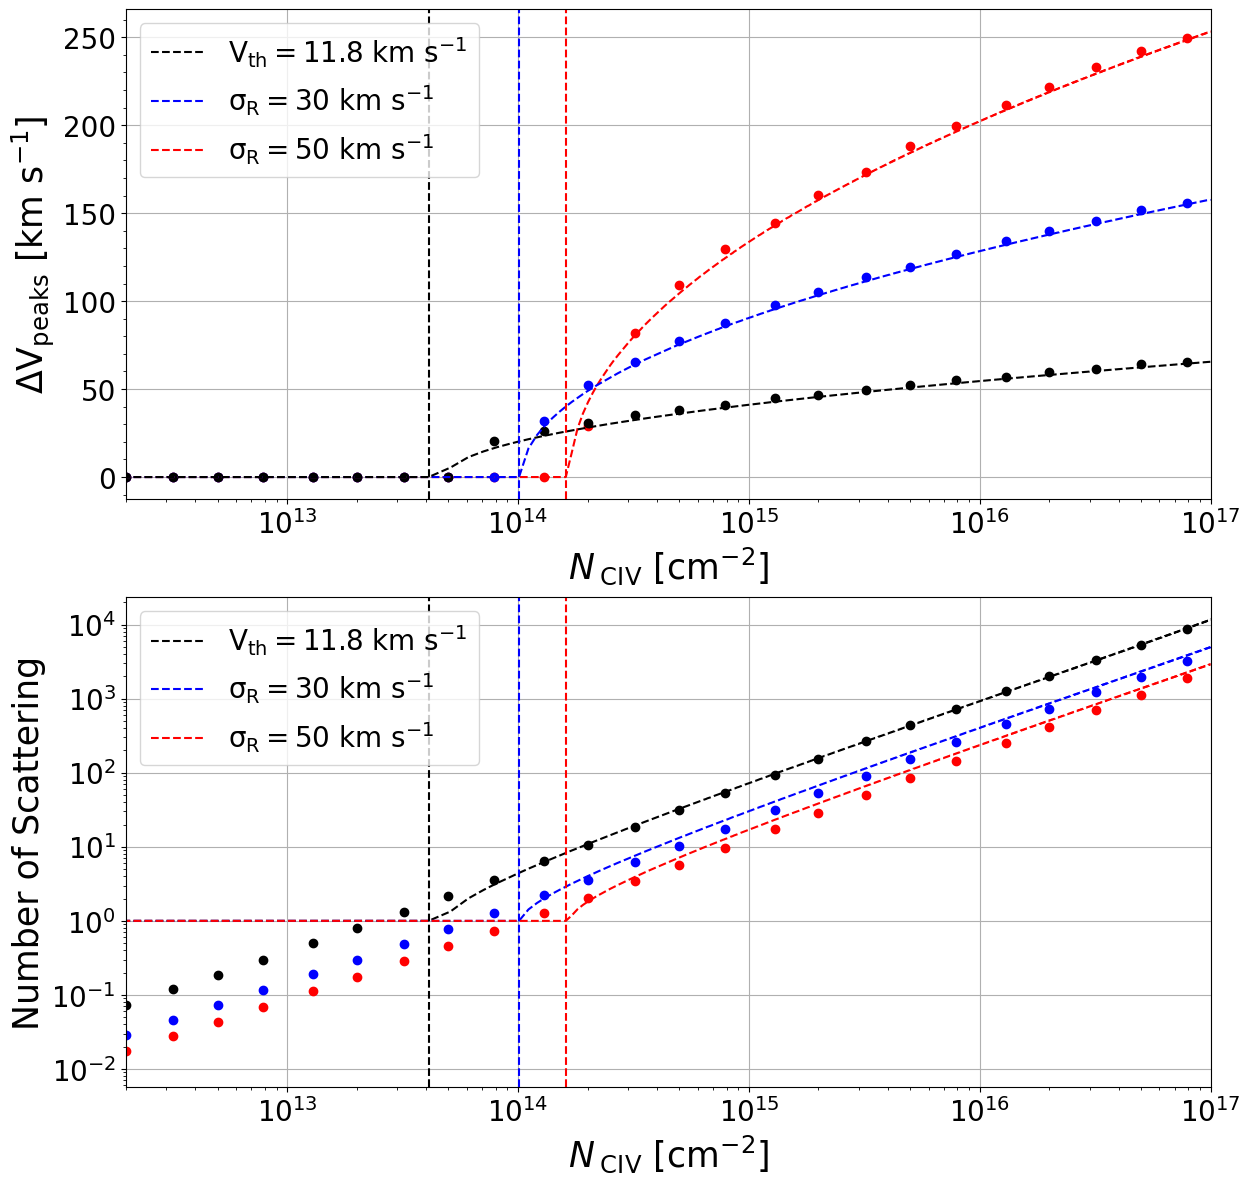

In [3]:
fig = plt.figure(1,figsize=(14,14))

plt.subplot(211)

plt.plot(tot_xx_50,tot_V_K_peak_50,'ro')
plt.plot(tot_xx_30,tot_V_K_peak_30,'bo')
# plt.plot(tot_xx_500,tot_V_K_peak_500,'bo')
plt.plot(tot_xx_118,tot_V_K_peak_118,'ko')

# plt.plot(tot_C_iv_2000,tot_V_del_peak_2000,'r--')
plt.plot(tot_C_iv_50,tot_V_del_peak_50,'r--')
plt.plot(tot_C_iv_30,tot_V_del_peak_30,'b--')
plt.plot(tot_C_iv_118,tot_V_del_peak_118,'k--')

t_1 = np.where(tot_V_del_peak_118 == 0)[0][-1]
t_2 = np.where(tot_V_del_peak_30 == 0)[0][-1]
t_3 = np.where(tot_V_del_peak_50 == 0)[0][-1]

plt.axvline(x=tot_C_iv_118[t_1],ymin=0,ymax=80,color='k',linestyle='--',label='${\mathrm{V_{th}}} = 11.8$ km s$^{-1}$')
plt.axvline(x=tot_C_iv_30[t_2],ymin=0,ymax=80,color='b',linestyle='--',label='${\mathrm{\sigma_{R}}} = 30$ km s$^{-1}$')
plt.axvline(x=tot_C_iv_50[t_3],ymin=0,ymax=80,color='r',linestyle='--',label='${\mathrm{\sigma_{R}}} = 50$ km s$^{-1}$')


# plt.axvline(x=7.58e+13,ymin=0,ymax=80,color='b',linestyle='--',label='${\mathrm{V_{th}}} = 26.3$ km s$^{-1}$')
# plt.axvline(x=1.07230e+14,ymin=0,ymax=80,color='r',linestyle='--',label='${\mathrm{V_{th}}} = 37.2$ km s$^{-1}$')



plt.xlabel(r'${N} \, _{\mathrm{C IV}}$ [cm$^{-2}$]',fontsize =25)
plt.xscale('log')
plt.xlim(2*10**12,10**17)
# plt.ylim(tot_V_K_peak_1.min()-2,tot_V_K_peak_1.max()+2)
plt.ylabel(r'$\Delta \mathrm{V}_{\mathrm{peaks}}$ [km s$^{-1}$]',fontsize =25)
plt.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.legend(fontsize=20,loc='upper left')

plt.subplot(212)
plt.plot(tot_xx_118,tot_scat_118,'ko')
plt.plot(tot_C_iv_118,tot_N_scat_118,'k--')
# plt.axvline(x=3.39e13,ymin=tot_N_scat_118.min()-10,ymax=2,color='k',linestyle='--',label='${\mathrm{V_{th}}} = 11.8$ km s$^{-1}$')
plt.plot(tot_xx_30,tot_scat_30,'bo')
plt.plot(tot_C_iv_30,tot_N_scat_30,'b--')

plt.plot(tot_xx_50,tot_scat_50,'ro')
plt.plot(tot_C_iv_50,tot_N_scat_50,'r--')
# plt.axvline(x=7.58e13,ymin=tot_N_scat_252.min()-10,ymax=2,color='b',linestyle='--',label='${\mathrm{V_{th}}} = 26.3$ km s$^{-1}$')

# plt.plot(tot_xx_2000,tot_N_scat_2000,'ro')
# plt.plot(tot_C_iv_2000,tot_N_scat_2000,'r--')
# plt.axvline(x=1.07e14,ymin=tot_N_scat_372.min()-10,ymax=2,color='r',linestyle='--',label='${\mathrm{V_{th}}} = 37.2$ km s$^{-1}$')

plt.axvline(x=tot_C_iv_118[t_1],ymin=0,ymax=80,color='k',linestyle='--',label='${\mathrm{V_{th}}} = 11.8$ km s$^{-1}$')
plt.axvline(x=tot_C_iv_30[t_2],ymin=0,ymax=80,color='b',linestyle='--',label='${\mathrm{\sigma_{R}}} = 30$ km s$^{-1}$')
plt.axvline(x=tot_C_iv_50[t_3],ymin=0,ymax=80,color='r',linestyle='--',label='${\mathrm{\sigma_{R}}} = 50$ km s$^{-1}$')


plt.xlabel(r'${N} \, _{\mathrm{C IV}}$ [cm$^{-2}$]',fontsize =25)
plt.xscale('log')
plt.yscale('log')
plt.xlim(2*10**12,10**17)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.ylim(scat.min(),scat.max()+2)
plt.ylabel(r'Number of Scattering',fontsize =25)
plt.minorticks_on()
plt.grid()
plt.legend(fontsize=20,loc='upper left')


# plt.savefig('/home/jin/바탕화면/simulation_vs_analyvic_jin_total.pdf',bbox_inches="tight")



Halo spectrum

In [4]:
check = 0
for tt,v_ran in enumerate(random_vel):
    n = 0
    if v_ran == 11.8 :
        index_v_ran = 1
        v_title = int(v_ran*10)
        v_ran = int(v_ran*10)
    elif v_ran < 100:
        index_v_ran = 1
        v_title = int(v_ran*10)
    elif v_ran >= 1000:
        index_v_ran = 3
        v_title = int(v_ran/10)
    else :
        index_v_ran = 2
        v_title = int(v_ran)
        
    globals()[f'halo_V_K_peak_{v_ran}'] = np.zeros(len(rr)*len(atom_N))
    globals()[f'V_H_peak_{v_ran}'] = np.zeros(len(rr)*len(atom_N))
    globals()[f'halo_scat_{v_ran}'] = np.zeros(len(rr)*len(atom_N))
    globals()[f'halo_xx_{v_ran}']= np.zeros(len(rr)*len(atom_N))
    iou = 1e5
    sig_ly, sig_c, N_CIV_0 = CIV(iou)
    globals()[f'halo_C_iv_{v_ran}'],globals()[f'halo_N_scat_{v_ran}'],globals()[f'halo_V_del_peak_{v_ran}'] = N_esc_scat(random_vel[tt]*1e5)

    for ii, index in enumerate(rr):
        index = int(index)
        for jj, atom in enumerate(atom_N):
            atom = int(atom)
            path_sp = f'{directory_1}N_atom{atom}0E+{index}_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran{v_title}E+0{index_v_ran}spec_com.dat'
            path_scat = f'{directory_1}N_atom{atom}0E+{index}_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran{v_title}E+0{index_v_ran}_f_esc.dat'

            try:
                data_sp = pd.read_csv(path_sp, sep='\s+', header=None)
                data_scat = pd.read_csv(path_scat, sep='\s+', header=None)
            except FileNotFoundError:
                print(f"파일을 찾을 수 없습니다: {path_sp}")
                check += 1
                continue

            globals()[f'data_scat_{atom}_{index}_{v_ran}'] = pd.read_csv(path_scat, sep='\s+', header=None)
            
            globals()[f'halo_scat_{v_ran}'][n] = float(globals()[f'data_scat_{atom}_{index}_{v_ran}'].iloc[0,4])
            
            # Read data
            globals()[f'data_halo_sp_{atom}_{index}_{v_ran}'] = pd.read_csv(path_sp, sep='\s+', header=None)
            globals()[f'halo_sp_dlam_{atom}_{index}_{v_ran}'] = globals()[f'data_halo_sp_{atom}_{index}_{v_ran}'][0]
            globals()[f'halo_sp_{atom}_{index}_{v_ran}'] = globals()[f'data_halo_sp_{atom}_{index}_{v_ran}'][2]

            # K and H line separate
            lam_c = (C_IV_K_A + C_IV_H_A) / 2
            # K line
            globals()[f'halo_lambda_K_{atom}_{index}_{v_ran}'] = globals()[f'halo_sp_dlam_{atom}_{index}_{v_ran}'][globals()[f'halo_sp_dlam_{atom}_{index}_{v_ran}'] <= lam_c]
            globals()[f'halo_flux_K_{atom}_{index}_{v_ran}'] = globals()[f'halo_sp_{atom}_{index}_{v_ran}'][globals()[f'halo_sp_dlam_{atom}_{index}_{v_ran}'] <= lam_c]
            # H line
            globals()[f'halo_lambda_H_{atom}_{index}_{v_ran}'] = globals()[f'halo_sp_dlam_{atom}_{index}_{v_ran}'][globals()[f'halo_sp_dlam_{atom}_{index}_{v_ran}'] >= lam_c]
            globals()[f'halo_flux_H_{atom}_{index}_{v_ran}'] = globals()[f'halo_sp_{atom}_{index}_{v_ran}'][globals()[f'halo_sp_dlam_{atom}_{index}_{v_ran}'] >= lam_c]

            # K line double peak separate

            Fraction =0   #0.000018
            C_IV_K_P = C_IV_K_A +  C_IV_K_A*Fraction 
            C_IV_K_N = C_IV_K_A  -  C_IV_K_A*Fraction 

            X_K_P = globals()[f'halo_lambda_K_{atom}_{index}_{v_ran}'][globals()[f'halo_lambda_K_{atom}_{index}_{v_ran}'] >= C_IV_K_P ].to_numpy()
            X_K_N = globals()[f'halo_lambda_K_{atom}_{index}_{v_ran}'][globals()[f'halo_lambda_K_{atom}_{index}_{v_ran}'] <= C_IV_K_N].to_numpy()
            filtered_series_K_pos_1 = globals()[f'halo_flux_K_{atom}_{index}_{v_ran}'][globals()[f'halo_lambda_K_{atom}_{index}_{v_ran}'] >= C_IV_K_P ].to_numpy()
            filtered_series_K_neg_1 = globals()[f'halo_flux_K_{atom}_{index}_{v_ran}'][globals()[f'halo_lambda_K_{atom}_{index}_{v_ran}'] <= C_IV_K_N].to_numpy()

            tt_K = (globals()[f'halo_lambda_K_{atom}_{index}_{v_ran}'] <= C_IV_K_N) | (globals()[f'halo_lambda_K_{atom}_{index}_{v_ran}'] >= C_IV_K_P )

            globals()[f'halo_x_K_{atom}_{index}_{v_ran}'] = np.compress(tt_K, globals()[f'halo_lambda_K_{atom}_{index}_{v_ran}'])
            globals()[f'halo_y_K_{atom}_{index}_{v_ran}'] = np.compress(tt_K, globals()[f'halo_flux_K_{atom}_{index}_{v_ran}'])

            # H line double peak separate
            C_IV_H_P = C_IV_H_A +  C_IV_H_A*Fraction 
            C_IV_H_N = C_IV_H_A -  C_IV_H_A*Fraction 

            X_H_P = globals()[f'halo_lambda_H_{atom}_{index}_{v_ran}'][globals()[f'halo_lambda_H_{atom}_{index}_{v_ran}'] >= C_IV_H_P].to_numpy()
            X_H_N = globals()[f'halo_lambda_H_{atom}_{index}_{v_ran}'][globals()[f'halo_lambda_H_{atom}_{index}_{v_ran}'] <= C_IV_H_N].to_numpy()
            filtered_series_H_pos_1 = globals()[f'halo_flux_H_{atom}_{index}_{v_ran}'][globals()[f'halo_lambda_H_{atom}_{index}_{v_ran}'] >= C_IV_H_P].to_numpy()
            filtered_series_H_neg_1 = globals()[f'halo_flux_H_{atom}_{index}_{v_ran}'][globals()[f'halo_lambda_H_{atom}_{index}_{v_ran}'] <= C_IV_H_N].to_numpy()

            tt_H = (globals()[f'halo_lambda_H_{atom}_{index}_{v_ran}'] <= C_IV_H_N) | (globals()[f'halo_lambda_H_{atom}_{index}_{v_ran}'] >= C_IV_H_P)

            globals()[f'halo_x_H_{atom}_{index}_{v_ran}'] = np.compress(tt_H, globals()[f'halo_lambda_H_{atom}_{index}_{v_ran}'])
            globals()[f'halo_y_H_{atom}_{index}_{v_ran}'] = np.compress(tt_H, globals()[f'halo_flux_H_{atom}_{index}_{v_ran}'])

            # Get peak indices
            K_p_1 = np.argmax(filtered_series_K_pos_1)
            K_n_1 = np.argmax(filtered_series_K_neg_1)

            H_p_1 = np.argmax(filtered_series_H_pos_1)
            H_n_1 = np.argmax(filtered_series_H_neg_1)

            lam_K_R = X_K_P[K_p_1]
            lam_K_B = X_K_N[K_n_1]
            
            lam_H_R = X_H_P[H_p_1]
            lam_H_B = X_H_P[H_n_1]

            Dlam = lam_K_R - lam_K_B
            vv = v_ran * 1e4

            # if vv / v_th_CIV < 1.2:
            #     dK_H = (1548.218 - 1548.156) * 1.5 
            # else:
            #     dK_H = (1548.218 - 1548.156) * 0.85 
            dK_H = 0.1
            if Dlam <= dK_H:
                del_V_peak_K = 0
            else:
                del_V_peak_K = (Dlam / C_IV_K_A) * cc / 1e5     

            globals()[f'halo_V_K_peak_{v_ran}'][n] = del_V_peak_K
            globals()[f'halo_xx_{v_ran}'][n] = 10**index * atom / 10
            n += 1

print(check)


0


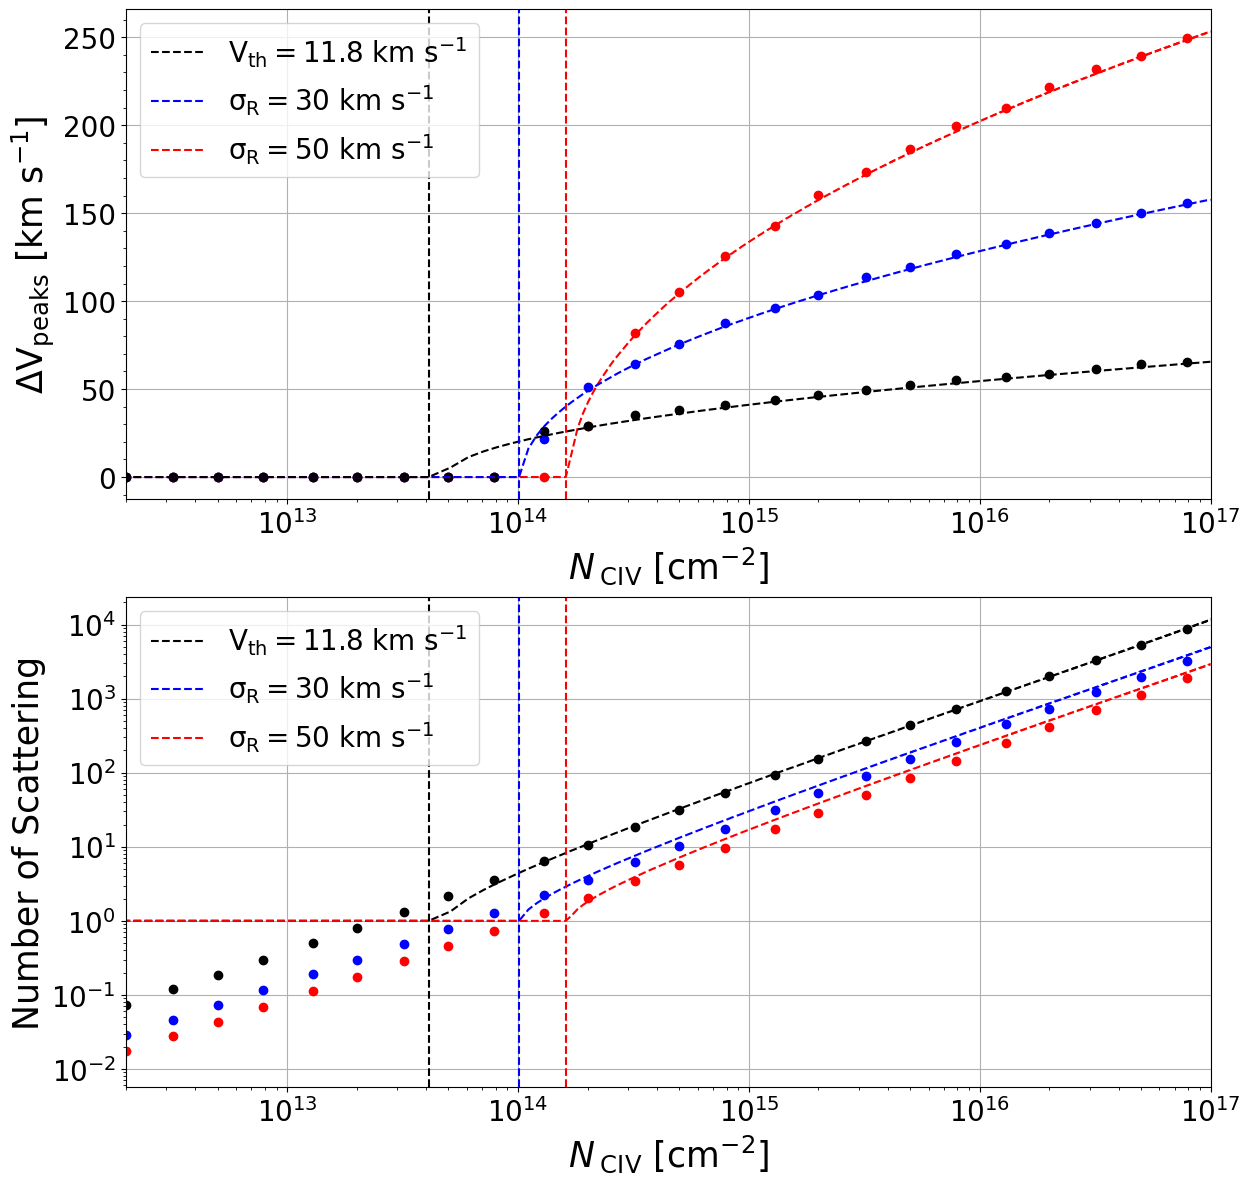

In [5]:
fig = plt.figure(1,figsize=(14,14))

plt.subplot(211)

plt.plot(halo_xx_50,halo_V_K_peak_50,'ro')
plt.plot(halo_xx_30,halo_V_K_peak_30,'bo')
# plt.plot(halo_xx_500,halo_V_K_peak_500,'bo')
plt.plot(halo_xx_118,halo_V_K_peak_118,'ko')

# plt.plot(halo_C_iv_2000,halo_V_del_peak_2000,'r--')
plt.plot(halo_C_iv_50,halo_V_del_peak_50,'r--')
plt.plot(halo_C_iv_30,halo_V_del_peak_30,'b--')
plt.plot(halo_C_iv_118,halo_V_del_peak_118,'k--')

t_1 = np.where(halo_V_del_peak_118 == 0)[0][-1]
t_2 = np.where(halo_V_del_peak_30 == 0)[0][-1]
t_3 = np.where(halo_V_del_peak_50 == 0)[0][-1]

plt.axvline(x=halo_C_iv_118[t_1],ymin=0,ymax=80,color='k',linestyle='--',label='${\mathrm{V_{th}}} = 11.8$ km s$^{-1}$')
plt.axvline(x=halo_C_iv_30[t_2],ymin=0,ymax=80,color='b',linestyle='--',label='${\mathrm{\sigma_{R}}} = 30$ km s$^{-1}$')
plt.axvline(x=halo_C_iv_50[t_3],ymin=0,ymax=80,color='r',linestyle='--',label='${\mathrm{\sigma_{R}}} = 50$ km s$^{-1}$')


# plt.axvline(x=7.58e+13,ymin=0,ymax=80,color='b',linestyle='--',label='${\mathrm{V_{th}}} = 26.3$ km s$^{-1}$')
# plt.axvline(x=1.07230e+14,ymin=0,ymax=80,color='r',linestyle='--',label='${\mathrm{V_{th}}} = 37.2$ km s$^{-1}$')



plt.xlabel(r'${N} \, _{\mathrm{C IV}}$ [cm$^{-2}$]',fontsize =25)
plt.xscale('log')
plt.xlim(2*10**12,10**17)
# plt.ylim(halo_V_K_peak_1.min()-2,halo_V_K_peak_1.max()+2)
plt.ylabel(r'$\Delta \mathrm{V}_{\mathrm{peaks}}$ [km s$^{-1}$]',fontsize =25)
plt.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.legend(fontsize=20,loc='upper left')

plt.subplot(212)
plt.plot(halo_xx_118,halo_scat_118,'ko')
plt.plot(halo_C_iv_118,halo_N_scat_118,'k--')
# plt.axvline(x=3.39e13,ymin=halo_N_scat_118.min()-10,ymax=2,color='k',linestyle='--',label='${\mathrm{V_{th}}} = 11.8$ km s$^{-1}$')
plt.plot(halo_xx_30,halo_scat_30,'bo')
plt.plot(halo_C_iv_30,halo_N_scat_30,'b--')

plt.plot(halo_xx_50,halo_scat_50,'ro')
plt.plot(halo_C_iv_50,halo_N_scat_50,'r--')
# plt.axvline(x=7.58e13,ymin=halo_N_scat_252.min()-10,ymax=2,color='b',linestyle='--',label='${\mathrm{V_{th}}} = 26.3$ km s$^{-1}$')

# plt.plot(halo_xx_2000,halo_N_scat_2000,'ro')
# plt.plot(halo_C_iv_2000,halo_N_scat_2000,'r--')
# plt.axvline(x=1.07e14,ymin=halo_N_scat_372.min()-10,ymax=2,color='r',linestyle='--',label='${\mathrm{V_{th}}} = 37.2$ km s$^{-1}$')

plt.axvline(x=halo_C_iv_118[t_1],ymin=0,ymax=80,color='k',linestyle='--',label='${\mathrm{V_{th}}} = 11.8$ km s$^{-1}$')
plt.axvline(x=halo_C_iv_30[t_2],ymin=0,ymax=80,color='b',linestyle='--',label='${\mathrm{\sigma_{R}}} = 30$ km s$^{-1}$')
plt.axvline(x=halo_C_iv_50[t_3],ymin=0,ymax=80,color='r',linestyle='--',label='${\mathrm{\sigma_{R}}} = 50$ km s$^{-1}$')


plt.xlabel(r'${N} \, _{\mathrm{C IV}}$ [cm$^{-2}$]',fontsize =25)
plt.xscale('log')
plt.yscale('log')
plt.xlim(2*10**12,10**17)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.ylim(scat.min(),scat.max()+2)
plt.ylabel(r'Number of Scattering',fontsize =25)
plt.minorticks_on()
plt.grid()
plt.legend(fontsize=20,loc='upper left')


# plt.savefig('/home/jin/바탕화면/simulation_vs_analyvic_jin_halo.pdf',bbox_inches="tight")



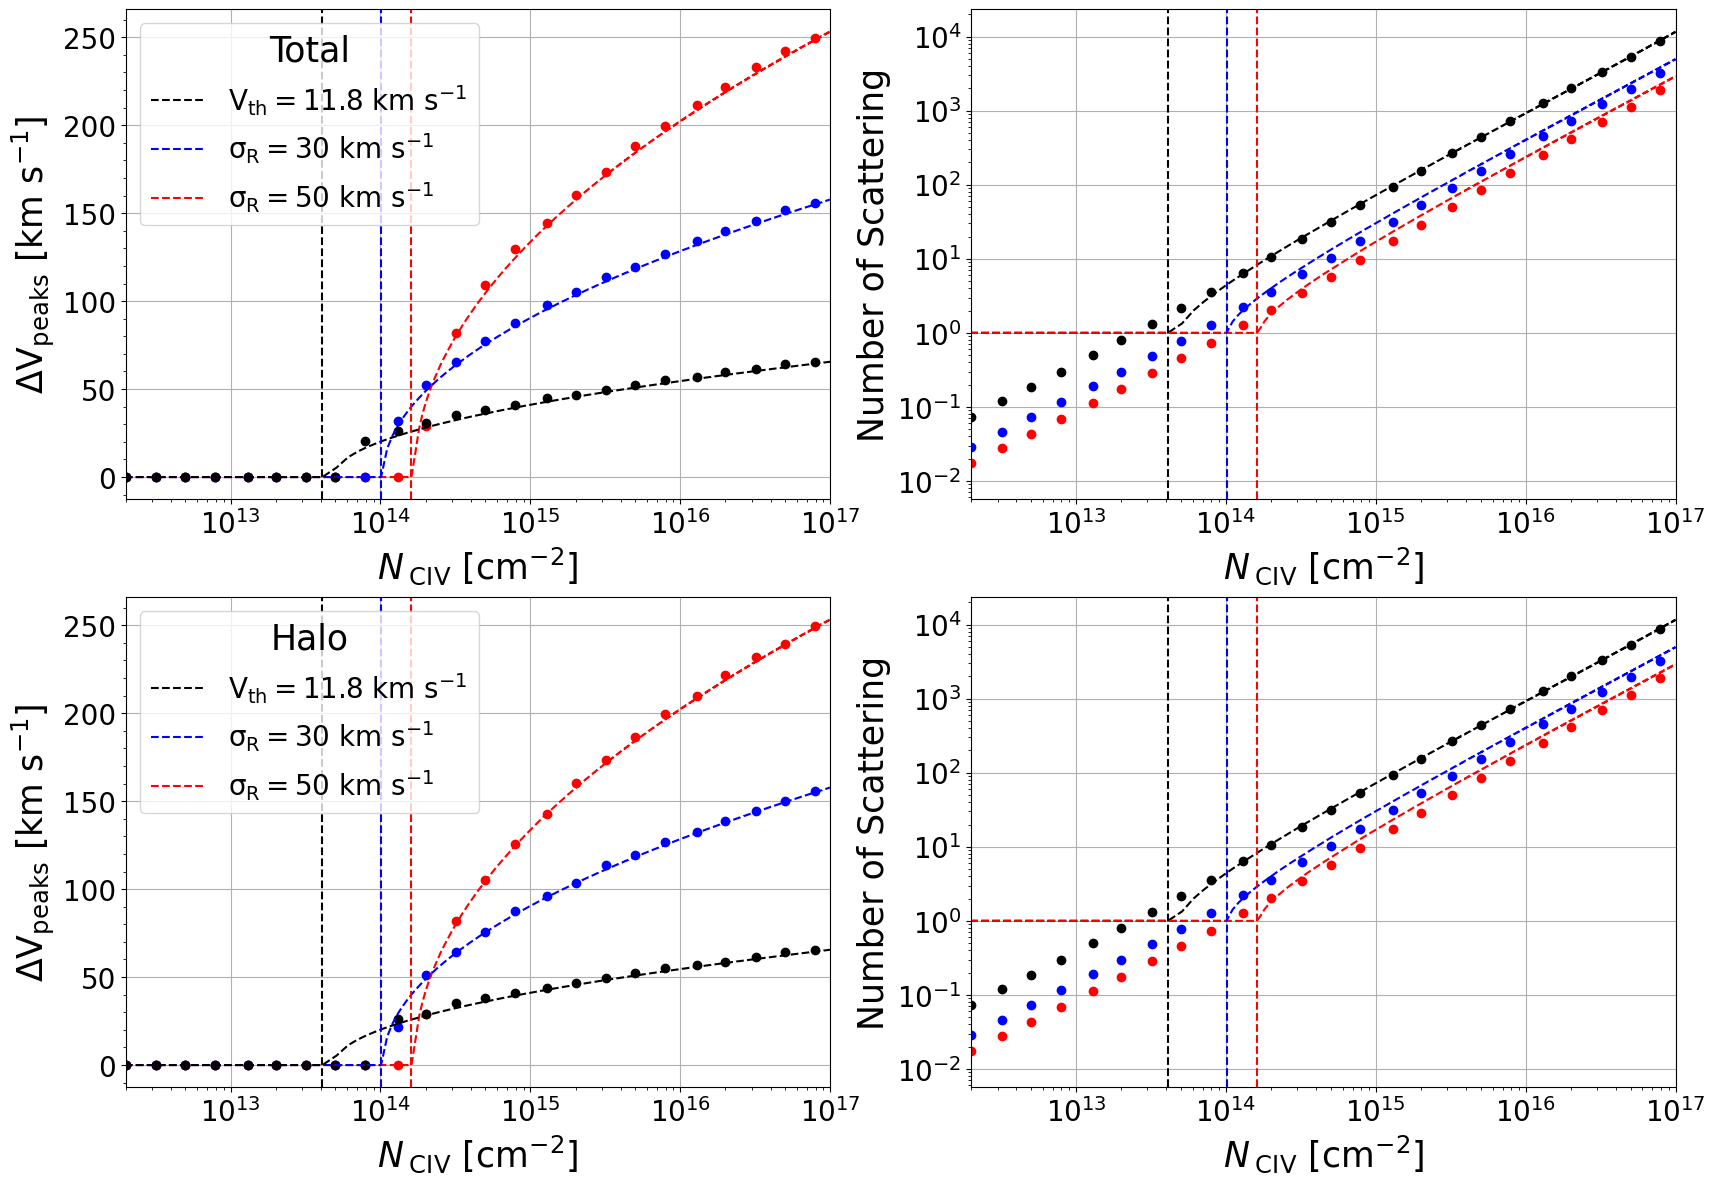

In [6]:
fig = plt.figure(1,figsize=(20,14))

plt.subplot(221)

plt.plot(tot_xx_50,tot_V_K_peak_50,'ro')
plt.plot(tot_xx_30,tot_V_K_peak_30,'bo')
# plt.plot(tot_xx_500,tot_V_K_peak_500,'bo')
plt.plot(tot_xx_118,tot_V_K_peak_118,'ko')

# plt.plot(tot_C_iv_2000,tot_V_del_peak_2000,'r--')
plt.plot(tot_C_iv_50,tot_V_del_peak_50,'r--')
plt.plot(tot_C_iv_30,tot_V_del_peak_30,'b--')
plt.plot(tot_C_iv_118,tot_V_del_peak_118,'k--')

t_1 = np.where(tot_V_del_peak_118 == 0)[0][-1]
t_2 = np.where(tot_V_del_peak_30 == 0)[0][-1]
t_3 = np.where(tot_V_del_peak_50 == 0)[0][-1]

plt.axvline(x=tot_C_iv_118[t_1],ymin=0,ymax=80,color='k',linestyle='--',label='${\mathrm{V_{th}}} = 11.8$ km s$^{-1}$')
plt.axvline(x=tot_C_iv_30[t_2],ymin=0,ymax=80,color='b',linestyle='--',label='${\mathrm{\sigma_{R}}} = 30$ km s$^{-1}$')
plt.axvline(x=tot_C_iv_50[t_3],ymin=0,ymax=80,color='r',linestyle='--',label='${\mathrm{\sigma_{R}}} = 50$ km s$^{-1}$')


# plt.axvline(x=7.58e+13,ymin=0,ymax=80,color='b',linestyle='--',label='${\mathrm{V_{th}}} = 26.3$ km s$^{-1}$')
# plt.axvline(x=1.07230e+14,ymin=0,ymax=80,color='r',linestyle='--',label='${\mathrm{V_{th}}} = 37.2$ km s$^{-1}$')



plt.xlabel(r'${N} \, _{\mathrm{C IV}}$ [cm$^{-2}$]',fontsize =25)
plt.xscale('log')
plt.xlim(2*10**12,10**17)
# plt.ylim(tot_V_K_peak_1.min()-2,tot_V_K_peak_1.max()+2)
plt.ylabel(r'$\Delta \mathrm{V}_{\mathrm{peaks}}$ [km s$^{-1}$]',fontsize =25)
plt.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.legend(fontsize=20,loc='upper left',title='Total',title_fontsize=25)

plt.subplot(222)
plt.plot(tot_xx_118,tot_scat_118,'ko')
plt.plot(tot_C_iv_118,tot_N_scat_118,'k--')
# plt.axvline(x=3.39e13,ymin=tot_N_scat_118.min()-10,ymax=2,color='k',linestyle='--',label='${\mathrm{V_{th}}} = 11.8$ km s$^{-1}$')
plt.plot(tot_xx_30,tot_scat_30,'bo')
plt.plot(tot_C_iv_30,tot_N_scat_30,'b--')

plt.plot(tot_xx_50,tot_scat_50,'ro')
plt.plot(tot_C_iv_50,tot_N_scat_50,'r--')
# plt.axvline(x=7.58e13,ymin=tot_N_scat_252.min()-10,ymax=2,color='b',linestyle='--',label='${\mathrm{V_{th}}} = 26.3$ km s$^{-1}$')

# plt.plot(tot_xx_2000,tot_N_scat_2000,'ro')
# plt.plot(tot_C_iv_2000,tot_N_scat_2000,'r--')
# plt.axvline(x=1.07e14,ymin=tot_N_scat_372.min()-10,ymax=2,color='r',linestyle='--',label='${\mathrm{V_{th}}} = 37.2$ km s$^{-1}$')

plt.axvline(x=tot_C_iv_118[t_1],ymin=0,ymax=80,color='k',linestyle='--',label='${\mathrm{V_{th}}} = 11.8$ km s$^{-1}$')
plt.axvline(x=tot_C_iv_30[t_2],ymin=0,ymax=80,color='b',linestyle='--',label='${\mathrm{\sigma_{R}}} = 30$ km s$^{-1}$')
plt.axvline(x=tot_C_iv_50[t_3],ymin=0,ymax=80,color='r',linestyle='--',label='${\mathrm{\sigma_{R}}} = 50$ km s$^{-1}$')


plt.xlabel(r'${N} \, _{\mathrm{C IV}}$ [cm$^{-2}$]',fontsize =25)
plt.xscale('log')
plt.yscale('log')
plt.xlim(2*10**12,10**17)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.ylim(scat.min(),scat.max()+2)
plt.ylabel(r'Number of Scattering',fontsize =25)
plt.minorticks_on()
plt.grid()

plt.subplot(223)

plt.plot(halo_xx_50,halo_V_K_peak_50,'ro')
plt.plot(halo_xx_30,halo_V_K_peak_30,'bo')
# plt.plot(halo_xx_500,halo_V_K_peak_500,'bo')
plt.plot(halo_xx_118,halo_V_K_peak_118,'ko')

# plt.plot(halo_C_iv_2000,halo_V_del_peak_2000,'r--')
plt.plot(halo_C_iv_50,halo_V_del_peak_50,'r--')
plt.plot(halo_C_iv_30,halo_V_del_peak_30,'b--')
plt.plot(halo_C_iv_118,halo_V_del_peak_118,'k--')

t_1 = np.where(halo_V_del_peak_118 == 0)[0][-1]
t_2 = np.where(halo_V_del_peak_30 == 0)[0][-1]
t_3 = np.where(halo_V_del_peak_50 == 0)[0][-1]

plt.axvline(x=halo_C_iv_118[t_1],ymin=0,ymax=80,color='k',linestyle='--',label='${\mathrm{V_{th}}} = 11.8$ km s$^{-1}$')
plt.axvline(x=halo_C_iv_30[t_2],ymin=0,ymax=80,color='b',linestyle='--',label='${\mathrm{\sigma_{R}}} = 30$ km s$^{-1}$')
plt.axvline(x=halo_C_iv_50[t_3],ymin=0,ymax=80,color='r',linestyle='--',label='${\mathrm{\sigma_{R}}} = 50$ km s$^{-1}$')


# plt.axvline(x=7.58e+13,ymin=0,ymax=80,color='b',linestyle='--',label='${\mathrm{V_{th}}} = 26.3$ km s$^{-1}$')
# plt.axvline(x=1.07230e+14,ymin=0,ymax=80,color='r',linestyle='--',label='${\mathrm{V_{th}}} = 37.2$ km s$^{-1}$')



plt.xlabel(r'${N} \, _{\mathrm{C IV}}$ [cm$^{-2}$]',fontsize =25)
plt.xscale('log')
plt.xlim(2*10**12,10**17)
# plt.ylim(halo_V_K_peak_1.min()-2,halo_V_K_peak_1.max()+2)
plt.ylabel(r'$\Delta \mathrm{V}_{\mathrm{peaks}}$ [km s$^{-1}$]',fontsize =25)
plt.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.legend(fontsize=20,loc='upper left',title='Halo',title_fontsize=25)

plt.subplot(224)
plt.plot(halo_xx_118,halo_scat_118,'ko')
plt.plot(halo_C_iv_118,halo_N_scat_118,'k--')
# plt.axvline(x=3.39e13,ymin=halo_N_scat_118.min()-10,ymax=2,color='k',linestyle='--',label='${\mathrm{V_{th}}} = 11.8$ km s$^{-1}$')
plt.plot(halo_xx_30,halo_scat_30,'bo')
plt.plot(halo_C_iv_30,halo_N_scat_30,'b--')

plt.plot(halo_xx_50,halo_scat_50,'ro')
plt.plot(halo_C_iv_50,halo_N_scat_50,'r--')
# plt.axvline(x=7.58e13,ymin=halo_N_scat_252.min()-10,ymax=2,color='b',linestyle='--',label='${\mathrm{V_{th}}} = 26.3$ km s$^{-1}$')

# plt.plot(halo_xx_2000,halo_N_scat_2000,'ro')
# plt.plot(halo_C_iv_2000,halo_N_scat_2000,'r--')
# plt.axvline(x=1.07e14,ymin=halo_N_scat_372.min()-10,ymax=2,color='r',linestyle='--',label='${\mathrm{V_{th}}} = 37.2$ km s$^{-1}$')

plt.axvline(x=halo_C_iv_118[t_1],ymin=0,ymax=80,color='k',linestyle='--',label='${\mathrm{V_{th}}} = 11.8$ km s$^{-1}$')
plt.axvline(x=halo_C_iv_30[t_2],ymin=0,ymax=80,color='b',linestyle='--',label='${\mathrm{\sigma_{R}}} = 30$ km s$^{-1}$')
plt.axvline(x=halo_C_iv_50[t_3],ymin=0,ymax=80,color='r',linestyle='--',label='${\mathrm{\sigma_{R}}} = 50$ km s$^{-1}$')


plt.xlabel(r'${N} \, _{\mathrm{C IV}}$ [cm$^{-2}$]',fontsize =25)
plt.xscale('log')
plt.yscale('log')
plt.xlim(2*10**12,10**17)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.ylim(scat.min(),scat.max()+2)
plt.ylabel(r'Number of Scattering',fontsize =25)
plt.minorticks_on()
plt.grid()
# plt.legend(fontsize=20,loc='upper left')




# plt.savefig('/home/jin/바탕화면/simulation_vs_analyvic_jin_total_halo.pdf',bbox_inches="tight")



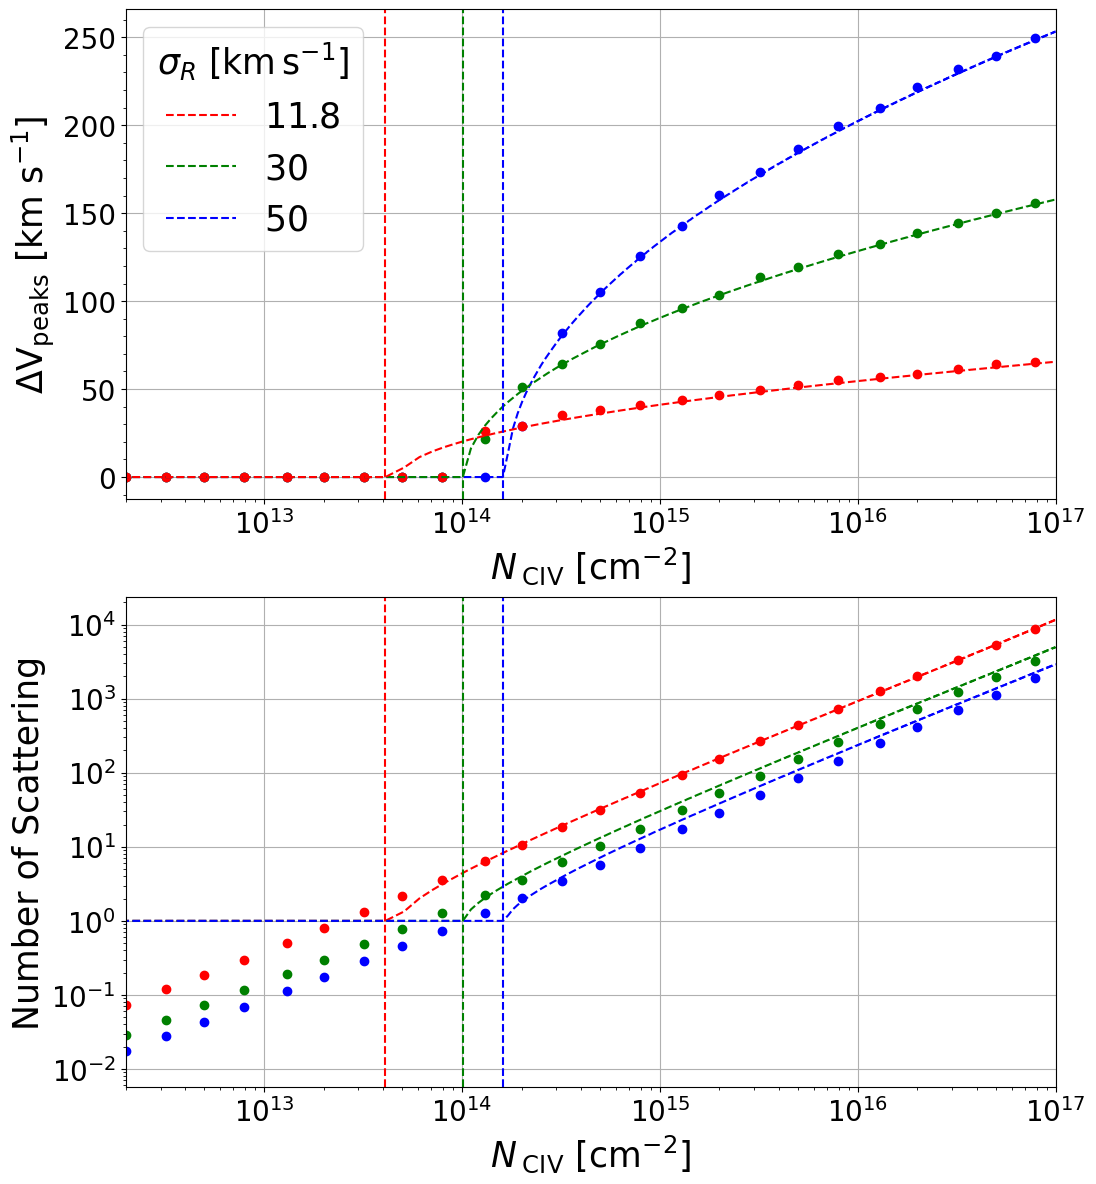

In [7]:
fig = plt.figure(1,figsize=(12,14))

plt.subplot(211)

plt.plot(halo_xx_50,halo_V_K_peak_50,'bo')
plt.plot(halo_xx_30,halo_V_K_peak_30,'go')
# plt.plot(halo_xx_500,halo_V_K_peak_500,'bo')
plt.plot(halo_xx_118,halo_V_K_peak_118,'ro')

# plt.plot(halo_C_iv_2000,halo_V_del_peak_2000,'r--')
plt.plot(halo_C_iv_50,halo_V_del_peak_50,'b--')
plt.plot(halo_C_iv_30,halo_V_del_peak_30,'g--')
plt.plot(halo_C_iv_118,halo_V_del_peak_118,'r--')

t_1 = np.where(halo_V_del_peak_118 == 0)[0][-1]
t_2 = np.where(halo_V_del_peak_30 == 0)[0][-1]
t_3 = np.where(halo_V_del_peak_50 == 0)[0][-1]

plt.axvline(x=halo_C_iv_118[t_1],ymin=0,ymax=80,color='r',linestyle='--',label='$ 11.8$')
plt.axvline(x=halo_C_iv_30[t_2],ymin=0,ymax=80,color='g',linestyle='--',label='$30$ ')
plt.axvline(x=halo_C_iv_50[t_3],ymin=0,ymax=80,color='b',linestyle='--',label='$50$')


# plt.axvline(x=7.58e+13,ymin=0,ymax=80,color='b',linestyle='--',label='${\mathrm{V_{th}}} = 26.3$ km s$^{-1}$')
# plt.axvline(x=1.07230e+14,ymin=0,ymax=80,color='r',linestyle='--',label='${\mathrm{V_{th}}} = 37.2$ km s$^{-1}$')



plt.xlabel(r'${N} \, _{\mathrm{C IV}}$ [cm$^{-2}$]',fontsize =25)
plt.xscale('log')
plt.xlim(2*10**12,10**17)
# plt.ylim(halo_V_K_peak_1.min()-2,halo_V_K_peak_1.max()+2)
plt.ylabel(r'$\Delta \mathrm{V}_{\mathrm{peaks}}$ [km s$^{-1}$]',fontsize =25)
plt.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.legend(fontsize=25,title=r'$\sigma_{R} ~ [\rm km\,s^{-1}]$',loc='upper left',title_fontsize=25)

plt.subplot(212)
plt.plot(halo_xx_118,halo_scat_118,'ro')
plt.plot(halo_C_iv_118,halo_N_scat_118,'r--')
# plt.axvline(x=3.39e13,ymin=halo_N_scat_118.min()-10,ymax=2,color='k',linestyle='--',label='${\mathrm{V_{th}}} = 11.8$ km s$^{-1}$')
plt.plot(halo_xx_30,halo_scat_30,'go')
plt.plot(halo_C_iv_30,halo_N_scat_30,'g--')

plt.plot(halo_xx_50,halo_scat_50,'bo')
plt.plot(halo_C_iv_50,halo_N_scat_50,'b--')
# plt.axvline(x=7.58e13,ymin=halo_N_scat_252.min()-10,ymax=2,color='b',linestyle='--',label='${\mathrm{V_{th}}} = 26.3$ km s$^{-1}$')

# plt.plot(halo_xx_2000,halo_N_scat_2000,'ro')
# plt.plot(halo_C_iv_2000,halo_N_scat_2000,'r--')
# plt.axvline(x=1.07e14,ymin=halo_N_scat_372.min()-10,ymax=2,color='r',linestyle='--',label='${\mathrm{V_{th}}} = 37.2$ km s$^{-1}$')

plt.axvline(x=halo_C_iv_118[t_1],ymin=0,ymax=80,color='r',linestyle='--',label='${\mathrm{V_{th}}} = 11.8$ km s$^{-1}$')
plt.axvline(x=halo_C_iv_30[t_2],ymin=0,ymax=80,color='g',linestyle='--',label='${\mathrm{\sigma_{R}}} = 30$ km s$^{-1}$')
plt.axvline(x=halo_C_iv_50[t_3],ymin=0,ymax=80,color='b',linestyle='--',label='${\mathrm{\sigma_{R}}} = 50$ km s$^{-1}$')


plt.xlabel(r'${N} \, _{\mathrm{C IV}}$ [cm$^{-2}$]',fontsize =25)
plt.xscale('log')
plt.yscale('log')
plt.xlim(2*10**12,10**17)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.ylim(scat.min(),scat.max()+2)
plt.ylabel(r'Number of Scattering',fontsize =25)
plt.minorticks_on()
plt.grid()
# plt.legend(fontsize=20,loc='upper left')

plt.savefig('/home/jin/바탕화면/simulation_vs_analyvic_jin_halo_mono.pdf',bbox_inches="tight")


In [8]:
def N_esc_scat(v_th):
    C_iv_N = np.linspace(1e12, 1e17, NN)
    # total_tau = np.zeros((len(C_iv_N), 1e6))

    # 벡터화된 tau 및 Voigt 프로파일 계산
    Voigt_profile = Voigt(xx,v_th,K_gamma, C_IV_K)
    tau_profile = tau(sig_c, C_iv_N[:, None]) * Voigt_profile


    # x_0 계산
    x_0 = np.zeros(len(C_iv_N))
    for ii, jj in enumerate(C_iv_N):
        x_p = np.where(np.diff(np.sign(1 - tau_profile[ii, :])))[0]
        x_0[ii] = xx[x_p].max() if x_p.size > 0 else 0

    del_lam_D = v_th / C_IV_K
    nu_0_K= cc/C_IV_K
    nu_esc = x_0*del_lam_D + nu_0_K
    V_del_peak = 2 * abs((nu_esc - nu_0_K)/nu_0_K) * cc/1e5 #km/s
    v_esc = x_0*v_th
    N_esc= 1/special.erfc(v_esc/v_th)

    return C_iv_N, N_esc , V_del_peak

/tmp/ipykernel_9317/4049425386.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=20)


Text(0.5, 0, '$\\Delta \\rm V $ [km/s]')

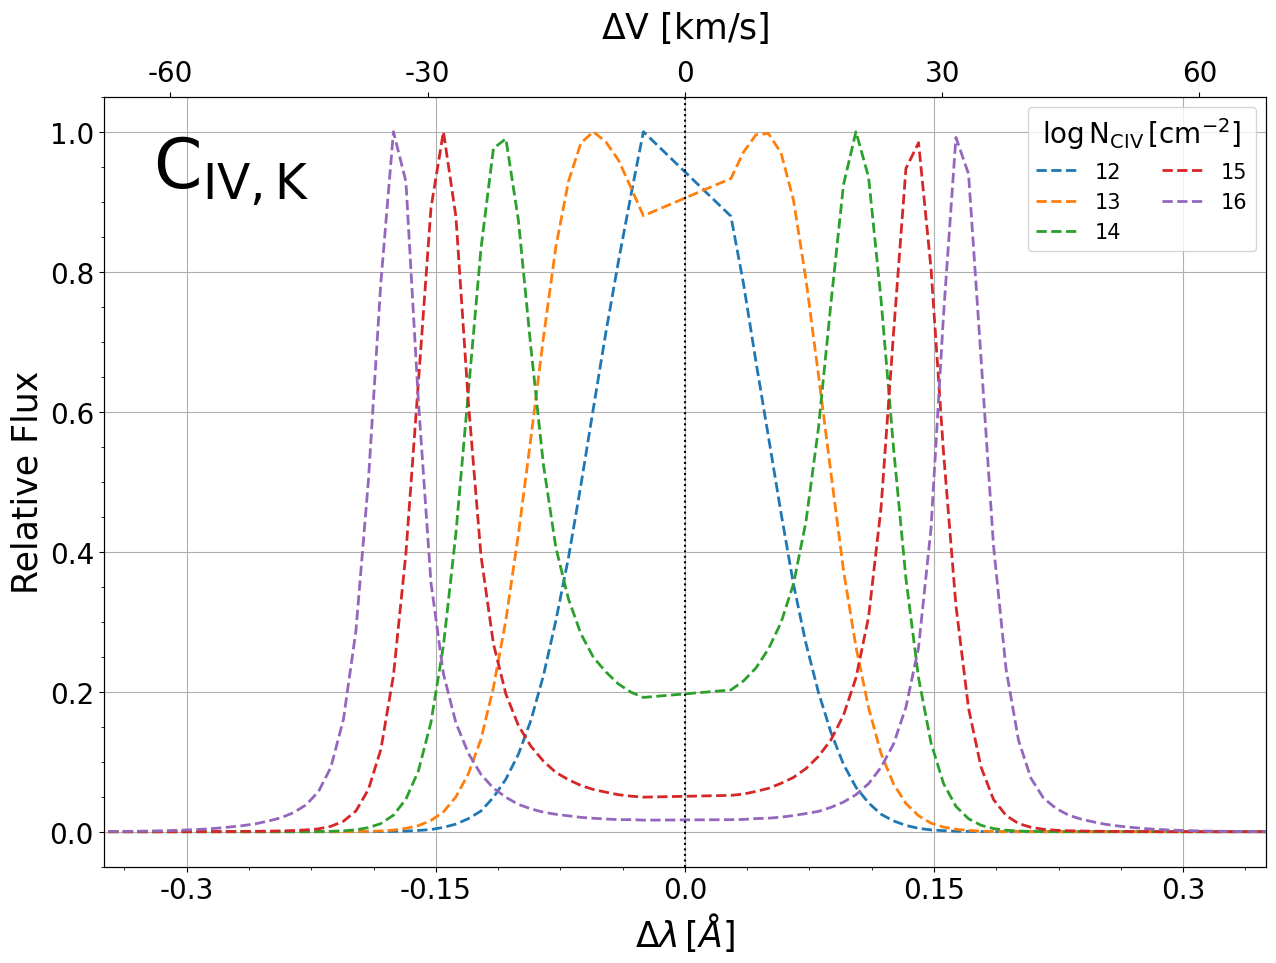

In [9]:



fig, ax1 = plt.subplots(figsize=(15, 10))
v_ran = 118


atom= 79

index= 12
ax1.plot( globals()[f'tot_x_K_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'tot_y_K_{atom}_{index}_{v_ran}']/globals()[f'tot_y_K_{atom}_{index}_{v_ran}'].max(),'--',lw=2,label = f'{index}')


index = 13
ax1.plot( globals()[f'tot_x_K_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'tot_y_K_{atom}_{index}_{v_ran}']/globals()[f'tot_y_K_{atom}_{index}_{v_ran}'].max(),'--',lw=2,label = f'{index}')

index = 14
ax1.plot( globals()[f'tot_x_K_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'tot_y_K_{atom}_{index}_{v_ran}']/globals()[f'tot_y_K_{atom}_{index}_{v_ran}'].max(),'--',lw=2,label = f'{index}')

index= 15
ax1.plot( globals()[f'tot_x_K_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'tot_y_K_{atom}_{index}_{v_ran}']/globals()[f'tot_y_K_{atom}_{index}_{v_ran}'].max(),'--',lw=2,label = f'{index}')

index= 16
ax1.plot( globals()[f'tot_x_K_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'tot_y_K_{atom}_{index}_{v_ran}']/globals()[f'tot_y_K_{atom}_{index}_{v_ran}'].max(),'--',lw=2,label = f'{index}')



ax1.set_xlim(-0.35, 0.35)
ax1.set_xticks(np.linspace(-0.3, 0.3, 5))  # x축 눈금 설정
ax1.set_xticklabels(np.round(np.linspace(-0.3, 0.3, 5),2), fontsize=20)
# ax1.set_xticklabels(np.linspace(-0.3, 0.3, 5), fontsize=20)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=20)
ax1.axvline(x=0, color='k', linestyle=':')
ax1.set_xlabel(r'$\Delta \lambda \, [\AA]$', fontsize=25)
ax1.set_ylabel('Relative Flux', fontsize=25)
ax1.legend(fontsize=15, title=r'$\log{\rm N_{\rm C IV}} \, [\rm cm^{-2}]$', title_fontsize=20, ncol=2)
ax1.minorticks_on()
ax1.grid(True)
ax1.text(-0.32, 0.92, r'$\rm C_{IV,K}$', fontweight='bold', fontsize=50)
# ax2 생성 및 설정
ax2 = ax1.twiny()

# # Convert x-axis limits from angstroms to km/s
xlim = ax1.get_xlim()
vel_xlim = (np.array(xlim) / C_IV_K_A) * cc / 1e5
ax2.set_xlim(vel_xlim)

# # ax2 설정
ax2.set_xticks(np.linspace(-60,60, 5))
ax2.set_xticklabels(np.linspace(-60, 60, 5).astype(int), fontsize=20)
ax2.set_xlabel(r'$\Delta \rm V $ [km/s]', fontsize=25, labelpad=15)
# plt.savefig('/home/jin/바탕화면/double_peak_K_line.pdf',bbox_inches="tight")

/tmp/ipykernel_9317/3988177962.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=20)


Text(0.5, 0, '$\\Delta \\rm V $ [km/s]')

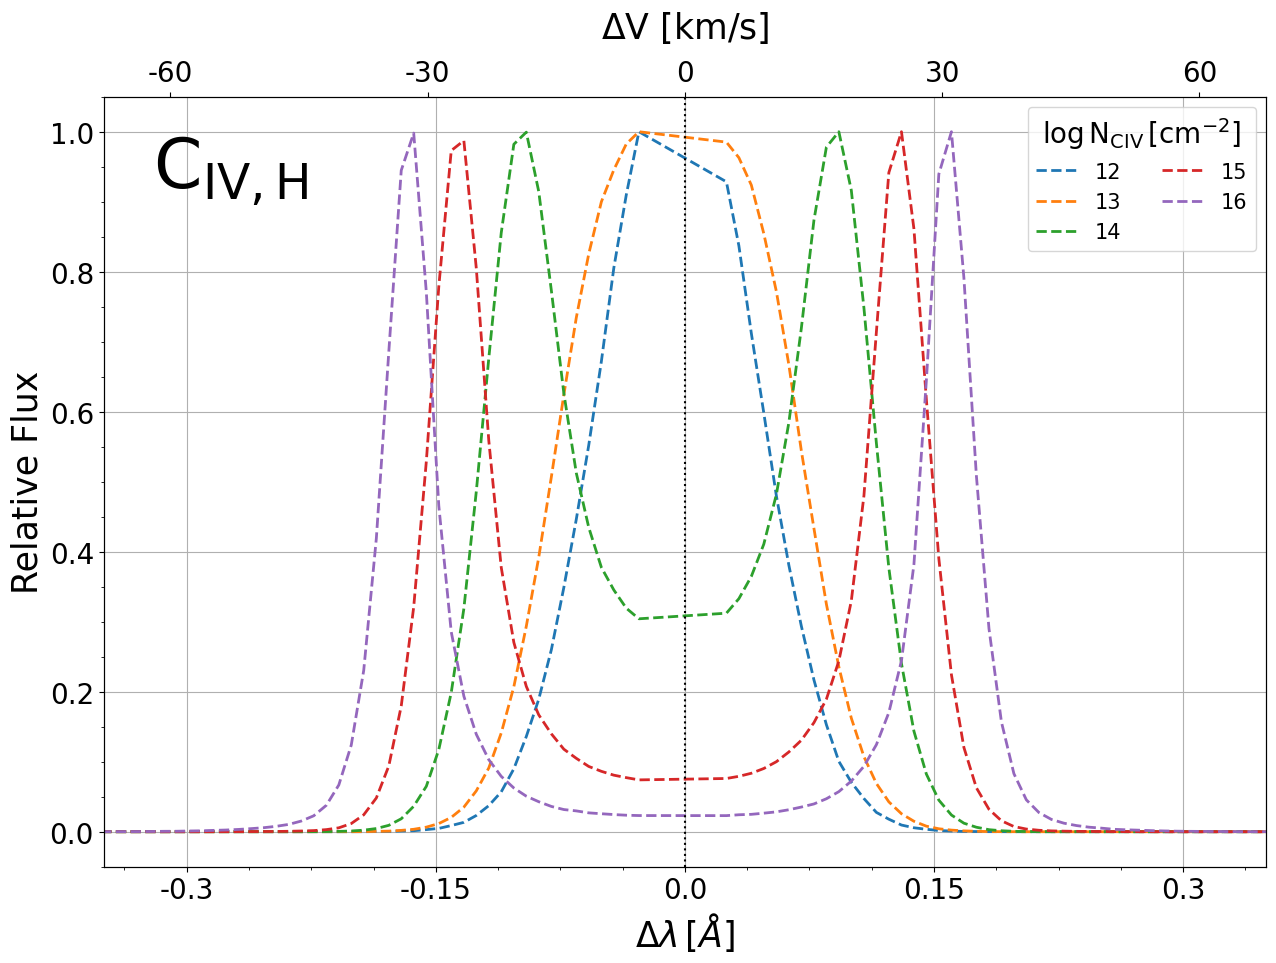

In [10]:



fig, ax1 = plt.subplots(figsize=(15, 10))
v_ran = 118


atom= 79

index= 12
ax1.plot( globals()[f'tot_x_H_{atom}_{index}_{v_ran}'] - C_IV_H_A,globals()[f'tot_y_H_{atom}_{index}_{v_ran}']/globals()[f'tot_y_H_{atom}_{index}_{v_ran}'].max(),'--',lw=2,label = f'{index}')


index = 13
ax1.plot( globals()[f'tot_x_H_{atom}_{index}_{v_ran}'] - C_IV_H_A,globals()[f'tot_y_H_{atom}_{index}_{v_ran}']/globals()[f'tot_y_H_{atom}_{index}_{v_ran}'].max(),'--',lw=2,label = f'{index}')

index = 14
ax1.plot( globals()[f'tot_x_H_{atom}_{index}_{v_ran}'] - C_IV_H_A,globals()[f'tot_y_H_{atom}_{index}_{v_ran}']/globals()[f'tot_y_H_{atom}_{index}_{v_ran}'].max(),'--',lw=2,label = f'{index}')

index= 15
ax1.plot( globals()[f'tot_x_H_{atom}_{index}_{v_ran}'] - C_IV_H_A,globals()[f'tot_y_H_{atom}_{index}_{v_ran}']/globals()[f'tot_y_H_{atom}_{index}_{v_ran}'].max(),'--',lw=2,label = f'{index}')

index= 16
ax1.plot( globals()[f'tot_x_H_{atom}_{index}_{v_ran}'] - C_IV_H_A,globals()[f'tot_y_H_{atom}_{index}_{v_ran}']/globals()[f'tot_y_H_{atom}_{index}_{v_ran}'].max(),'--',lw=2,label = f'{index}')



ax1.set_xlim(-0.35, 0.35)
ax1.set_xticks(np.linspace(-0.3, 0.3, 5))  # x축 눈금 설정
ax1.set_xticklabels(np.round(np.linspace(-0.3, 0.3, 5),2), fontsize=20)
# ax1.set_xticklabels(np.linspace(-0.3, 0.3, 5), fontsize=20)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=20)
ax1.axvline(x=0, color='k', linestyle=':')
ax1.set_xlabel(r'$\Delta \lambda \, [\AA]$', fontsize=25)
ax1.set_ylabel('Relative Flux', fontsize=25)
ax1.legend(fontsize=15, title=r'$\log{\rm N_{\rm C IV}} \, [\rm cm^{-2}]$', title_fontsize=20, ncol=2)
ax1.minorticks_on()
ax1.grid(True)
ax1.text(-0.32, 0.92, r'$\rm C_{IV,H}$', fontweight='bold', fontsize=50)
# ax2 생성 및 설정
ax2 = ax1.twiny()

# Convert x-axis limits from angstroms to km/s
xlim = ax1.get_xlim()
vel_xlim = (np.array(xlim) / C_IV_K_A) * cc / 1e5
ax2.set_xlim(vel_xlim)

# ax2 설정
ax2.set_xticks(np.linspace(-60,60, 5))
ax2.set_xticklabels(np.linspace(-60, 60, 5).astype(int), fontsize=20)
ax2.set_xlabel(r'$\Delta \rm V $ [km/s]', fontsize=25, labelpad=15)
# plt.savefig('/home/jin/바탕화면/double_peak_H_line.pdf',bbox_inches="tight")

/tmp/ipykernel_9317/3988177962.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=20)


Text(0.5, 0, '$\\Delta \\rm V $ [km/s]')

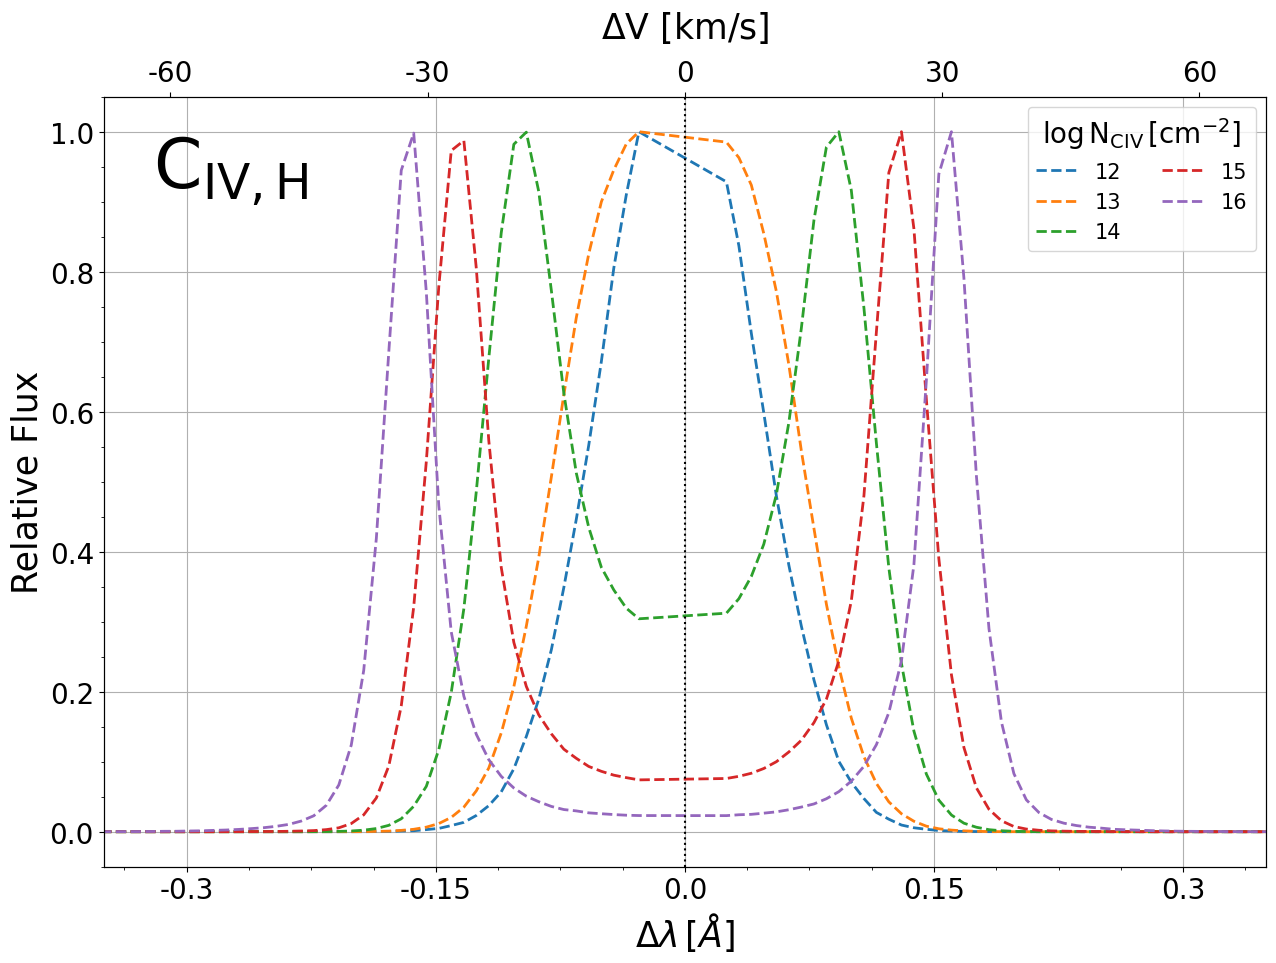

In [11]:



fig, ax1 = plt.subplots(figsize=(15, 10))
v_ran = 118


atom= 79

index= 12
ax1.plot( globals()[f'tot_x_H_{atom}_{index}_{v_ran}'] - C_IV_H_A,globals()[f'tot_y_H_{atom}_{index}_{v_ran}']/globals()[f'tot_y_H_{atom}_{index}_{v_ran}'].max(),'--',lw=2,label = f'{index}')


index = 13
ax1.plot( globals()[f'tot_x_H_{atom}_{index}_{v_ran}'] - C_IV_H_A,globals()[f'tot_y_H_{atom}_{index}_{v_ran}']/globals()[f'tot_y_H_{atom}_{index}_{v_ran}'].max(),'--',lw=2,label = f'{index}')

index = 14
ax1.plot( globals()[f'tot_x_H_{atom}_{index}_{v_ran}'] - C_IV_H_A,globals()[f'tot_y_H_{atom}_{index}_{v_ran}']/globals()[f'tot_y_H_{atom}_{index}_{v_ran}'].max(),'--',lw=2,label = f'{index}')

index= 15
ax1.plot( globals()[f'tot_x_H_{atom}_{index}_{v_ran}'] - C_IV_H_A,globals()[f'tot_y_H_{atom}_{index}_{v_ran}']/globals()[f'tot_y_H_{atom}_{index}_{v_ran}'].max(),'--',lw=2,label = f'{index}')

index= 16
ax1.plot( globals()[f'tot_x_H_{atom}_{index}_{v_ran}'] - C_IV_H_A,globals()[f'tot_y_H_{atom}_{index}_{v_ran}']/globals()[f'tot_y_H_{atom}_{index}_{v_ran}'].max(),'--',lw=2,label = f'{index}')



ax1.set_xlim(-0.35, 0.35)
ax1.set_xticks(np.linspace(-0.3, 0.3, 5))  # x축 눈금 설정
ax1.set_xticklabels(np.round(np.linspace(-0.3, 0.3, 5),2), fontsize=20)
# ax1.set_xticklabels(np.linspace(-0.3, 0.3, 5), fontsize=20)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=20)
ax1.axvline(x=0, color='k', linestyle=':')
ax1.set_xlabel(r'$\Delta \lambda \, [\AA]$', fontsize=25)
ax1.set_ylabel('Relative Flux', fontsize=25)
ax1.legend(fontsize=15, title=r'$\log{\rm N_{\rm C IV}} \, [\rm cm^{-2}]$', title_fontsize=20, ncol=2)
ax1.minorticks_on()
ax1.grid(True)
ax1.text(-0.32, 0.92, r'$\rm C_{IV,H}$', fontweight='bold', fontsize=50)
# ax2 생성 및 설정
ax2 = ax1.twiny()

# Convert x-axis limits from angstroms to km/s
xlim = ax1.get_xlim()
vel_xlim = (np.array(xlim) / C_IV_K_A) * cc / 1e5
ax2.set_xlim(vel_xlim)

# ax2 설정
ax2.set_xticks(np.linspace(-60,60, 5))
ax2.set_xticklabels(np.linspace(-60, 60, 5).astype(int), fontsize=20)
ax2.set_xlabel(r'$\Delta \rm V $ [km/s]', fontsize=25, labelpad=15)
# plt.savefig('/home/jin/바탕화면/double_peak_H_line.pdf',bbox_inches="tight")

/tmp/ipykernel_9317/853631426.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=20)


Text(0.5, 0, '$\\Delta \\rm V $ [km/s]')

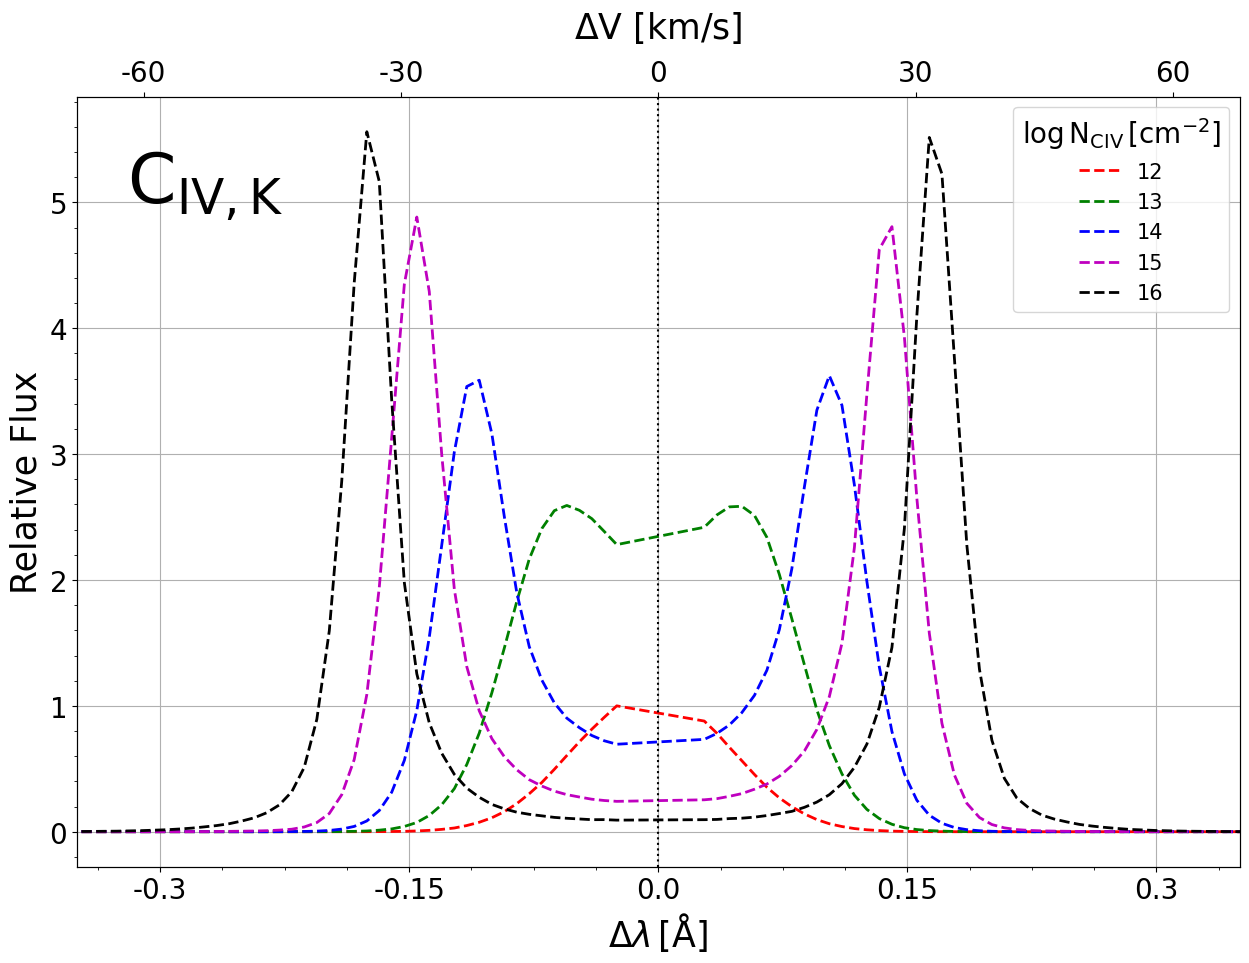

In [12]:
# fig= plt.figure(1,figsize=(15, 10))

fig, ax1 = plt.subplots(figsize=(15, 10))
v_ran = 118


atom= 79

index= 12
normal = globals()[f'tot_y_K_{atom}_{index}_{v_ran}'].max()
plt.plot( globals()[f'tot_x_K_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'tot_y_K_{atom}_{index}_{v_ran}']/normal,'r--',lw=2,label = f'{index}')
plt.plot( globals()[f'tot_x_H_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'tot_y_H_{atom}_{index}_{v_ran}']/normal,'r--')


index = 13
plt.plot( globals()[f'tot_x_K_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'tot_y_K_{atom}_{index}_{v_ran}']/normal,'g--',lw=2,label = f'{index}')
plt.plot( globals()[f'tot_x_H_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'tot_y_H_{atom}_{index}_{v_ran}']/normal,'g--')

index = 14
plt.plot( globals()[f'tot_x_K_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'tot_y_K_{atom}_{index}_{v_ran}']/normal,'b--',lw=2,label = f'{index}')
plt.plot( globals()[f'tot_x_H_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'tot_y_H_{atom}_{index}_{v_ran}']/normal,'b--')

index= 15
plt.plot( globals()[f'tot_x_K_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'tot_y_K_{atom}_{index}_{v_ran}']/normal,'m--',lw=2,label = f'{index}')
plt.plot( globals()[f'tot_x_H_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'tot_y_H_{atom}_{index}_{v_ran}']/normal,'m--')

index= 16
plt.plot( globals()[f'tot_x_K_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'tot_y_K_{atom}_{index}_{v_ran}']/normal,'k--',lw=2,label = f'{index}')
plt.plot( globals()[f'tot_x_H_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'tot_y_H_{atom}_{index}_{v_ran}']/normal,'k--')

# plt.xlim(-0.5,0.5)


# plt.xlim(-0.35, 0.35)
# plt.xticks(np.linspace(-0.3, 0.3, 5),fontsize=20)  # x축 눈금 설정
# # ax1.set_xticklabels(np.round(np.linspace(-0.3, 0.3, 5),2), fontsize=20)
# # ax1.set_xticklabels(np.linspace(-0.3, 0.3, 5), fontsize=20)
# plt.yticks( fontsize=20)
# # ax1.axvline(x=0, color='k', linestyle=':')
# plt.xlabel(r'$\Delta \lambda \, [\AA]$', fontsize=25)
# plt.ylabel('Relative Flux', fontsize=25)
# plt.legend(fontsize=15, title=r'$\log{\rm N_{\rm C IV}} \, [\rm cm^{-2}]$', title_fontsize=20, ncol=2)
# plt.minorticks_on()
# plt.grid(True)
# plt.text(-0.32, 5.0, r'$\rm C_{IV,K}$', fontweight='bold', fontsize=50)

ax1.set_xlim(-0.35, 0.35)
ax1.set_xticks(np.linspace(-0.3, 0.3, 5))  # x축 눈금 설정
ax1.set_xticklabels(np.round(np.linspace(-0.3, 0.3, 5),2), fontsize=20)
# ax1.set_xticklabels(np.linspace(-0.3, 0.3, 5), fontsize=20)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=20)
ax1.axvline(x=0, color='k', linestyle=':')
ax1.set_xlabel(r'$\Delta \lambda \, [\rm \AA]$', fontsize=25)
ax1.set_ylabel('Relative Flux', fontsize=25)
ax1.legend(fontsize=15, title=r'$\log{\rm N_{\rm C IV}} \, [\rm cm^{-2}]$', title_fontsize=20, ncol=1)
ax1.minorticks_on()
ax1.grid(True)
ax1.text(-0.32, 5.0, r'$\rm C_{IV,K}$', fontweight='bold', fontsize=50)
# ax2 생성 및 설정
ax2 = ax1.twiny()

# # Convert x-axis limits from angstroms to km/s
xlim = ax1.get_xlim()
vel_xlim = (np.array(xlim) / C_IV_K_A) * cc / 1e5
ax2.set_xlim(vel_xlim)

# # ax2 설정
ax2.set_xticks(np.linspace(-60,60, 5))
ax2.set_xticklabels(np.linspace(-60, 60, 5).astype(int), fontsize=20)
ax2.set_xlabel(r'$\Delta \rm V $ [km/s]', fontsize=25, labelpad=15)
# ax1.set_ylabel('Relative Flux', fontsize=25)
# plt.savefig('/home/jin/바탕화면/double_peak_K_line.pdf',bbox_inches="tight")

/tmp/ipykernel_9317/3103288978.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=20)


Text(0.5, 0, '$\\Delta \\rm V $ [km/s]')

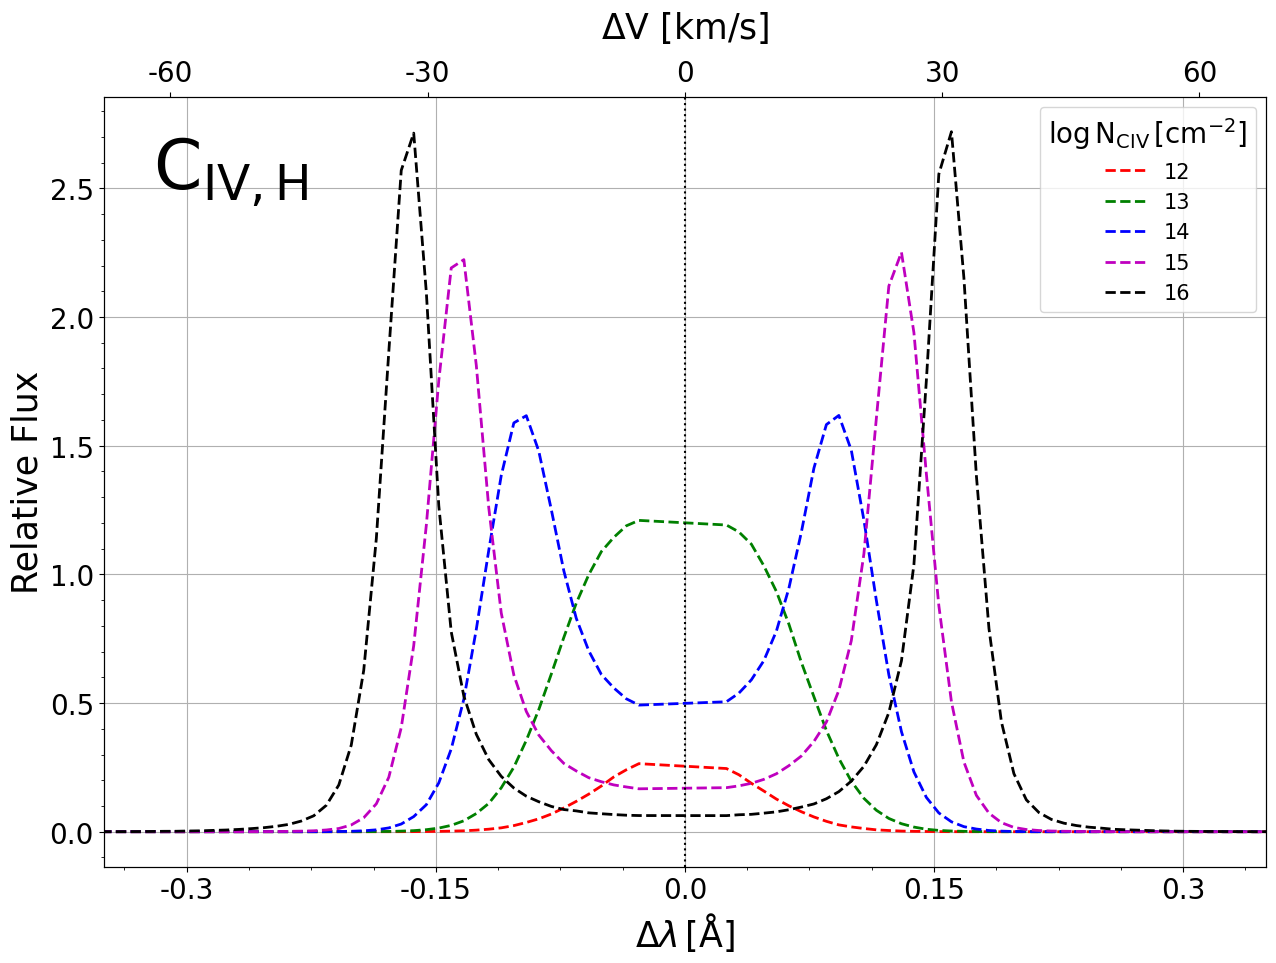

In [13]:
# fig= plt.figure(1,figsize=(15, 10))

fig, ax1 = plt.subplots(figsize=(15, 10))
v_ran = 118


atom= 79

index= 12
# normal = globals()[f'tot_y_H_{atom}_{index}_{v_ran}'].max()
plt.plot( globals()[f'tot_x_H_{atom}_{index}_{v_ran}'] - C_IV_H_A,globals()[f'tot_y_H_{atom}_{index}_{v_ran}']/normal,'r--',lw=2,label = f'{index}')



index = 13
plt.plot( globals()[f'tot_x_H_{atom}_{index}_{v_ran}'] - C_IV_H_A,globals()[f'tot_y_H_{atom}_{index}_{v_ran}']/normal,'g--',lw=2,label = f'{index}')


index = 14
plt.plot( globals()[f'tot_x_H_{atom}_{index}_{v_ran}'] - C_IV_H_A,globals()[f'tot_y_H_{atom}_{index}_{v_ran}']/normal,'b--',lw=2,label = f'{index}')


index= 15
plt.plot( globals()[f'tot_x_H_{atom}_{index}_{v_ran}'] - C_IV_H_A,globals()[f'tot_y_H_{atom}_{index}_{v_ran}']/normal,'m--',lw=2,label = f'{index}')

index= 16
plt.plot( globals()[f'tot_x_H_{atom}_{index}_{v_ran}'] - C_IV_H_A,globals()[f'tot_y_H_{atom}_{index}_{v_ran}']/normal,'k--',lw=2,label = f'{index}')


# plt.xlim(-0.5,0.5)


# plt.xlim(-0.35, 0.35)
# plt.xticks(np.linspace(-0.3, 0.3, 5),fontsize=20)  # x축 눈금 설정
# # ax1.set_xticklabels(np.round(np.linspace(-0.3, 0.3, 5),2), fontsize=20)
# # ax1.set_xticklabels(np.linspace(-0.3, 0.3, 5), fontsize=20)
# plt.yticks( fontsize=20)
# # ax1.axvline(x=0, color='k', linestyle=':')
# plt.xlabel(r'$\Delta \lambda \, [\AA]$', fontsize=25)
# plt.ylabel('Relative Flux', fontsize=25)
# plt.legend(fontsize=15, title=r'$\log{\rm N_{\rm C IV}} \, [\rm cm^{-2}]$', title_fontsize=20, ncol=2)
# plt.minorticks_on()
# plt.grid(True)
# plt.text(-0.32, 5.0, r'$\rm C_{IV,K}$', fontweight='bold', fontsize=50)

ax1.set_xlim(-0.35, 0.35)
ax1.set_xticks(np.linspace(-0.3, 0.3, 5))  # x축 눈금 설정
ax1.set_xticklabels(np.round(np.linspace(-0.3, 0.3, 5),2), fontsize=20)
# ax1.set_xticklabels([-3.0,-2.0,-1.0,0,1.0,2.0,3.0], fontsize=20)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=20)
ax1.axvline(x=0, color='k', linestyle=':')
ax1.set_xlabel(r'$\Delta \lambda \, [\rm \AA]$', fontsize=25)
ax1.set_ylabel('Relative Flux', fontsize=25)
ax1.legend(fontsize=15, title=r'$\log{\rm N_{\rm C IV}} \, [\rm cm^{-2}]$', title_fontsize=20, ncol=1)
ax1.minorticks_on()
ax1.grid(True)
ax1.text(-0.32, 2.5, r'$\rm C_{IV,H}$', fontweight='bold', fontsize=50)
# ax2 생성 및 설정
ax2 = ax1.twiny()

# # Convert x-axis limits from angstroms to km/s
xlim = ax1.get_xlim()
vel_xlim = (np.array(xlim) / C_IV_K_A) * cc / 1e5
ax2.set_xlim(vel_xlim)

# # ax2 설정
ax2.set_xticks(np.linspace(-60,60, 5))
ax2.set_xticklabels(np.linspace(-60, 60, 5).astype(int), fontsize=20)
ax2.set_xlabel(r'$\Delta \rm V $ [km/s]', fontsize=25, labelpad=15)
# plt.savefig('/home/jin/바탕화면/double_peak_H_line.pdf',bbox_inches="tight")

Text(485, 2.0, '  Halo \n H line')

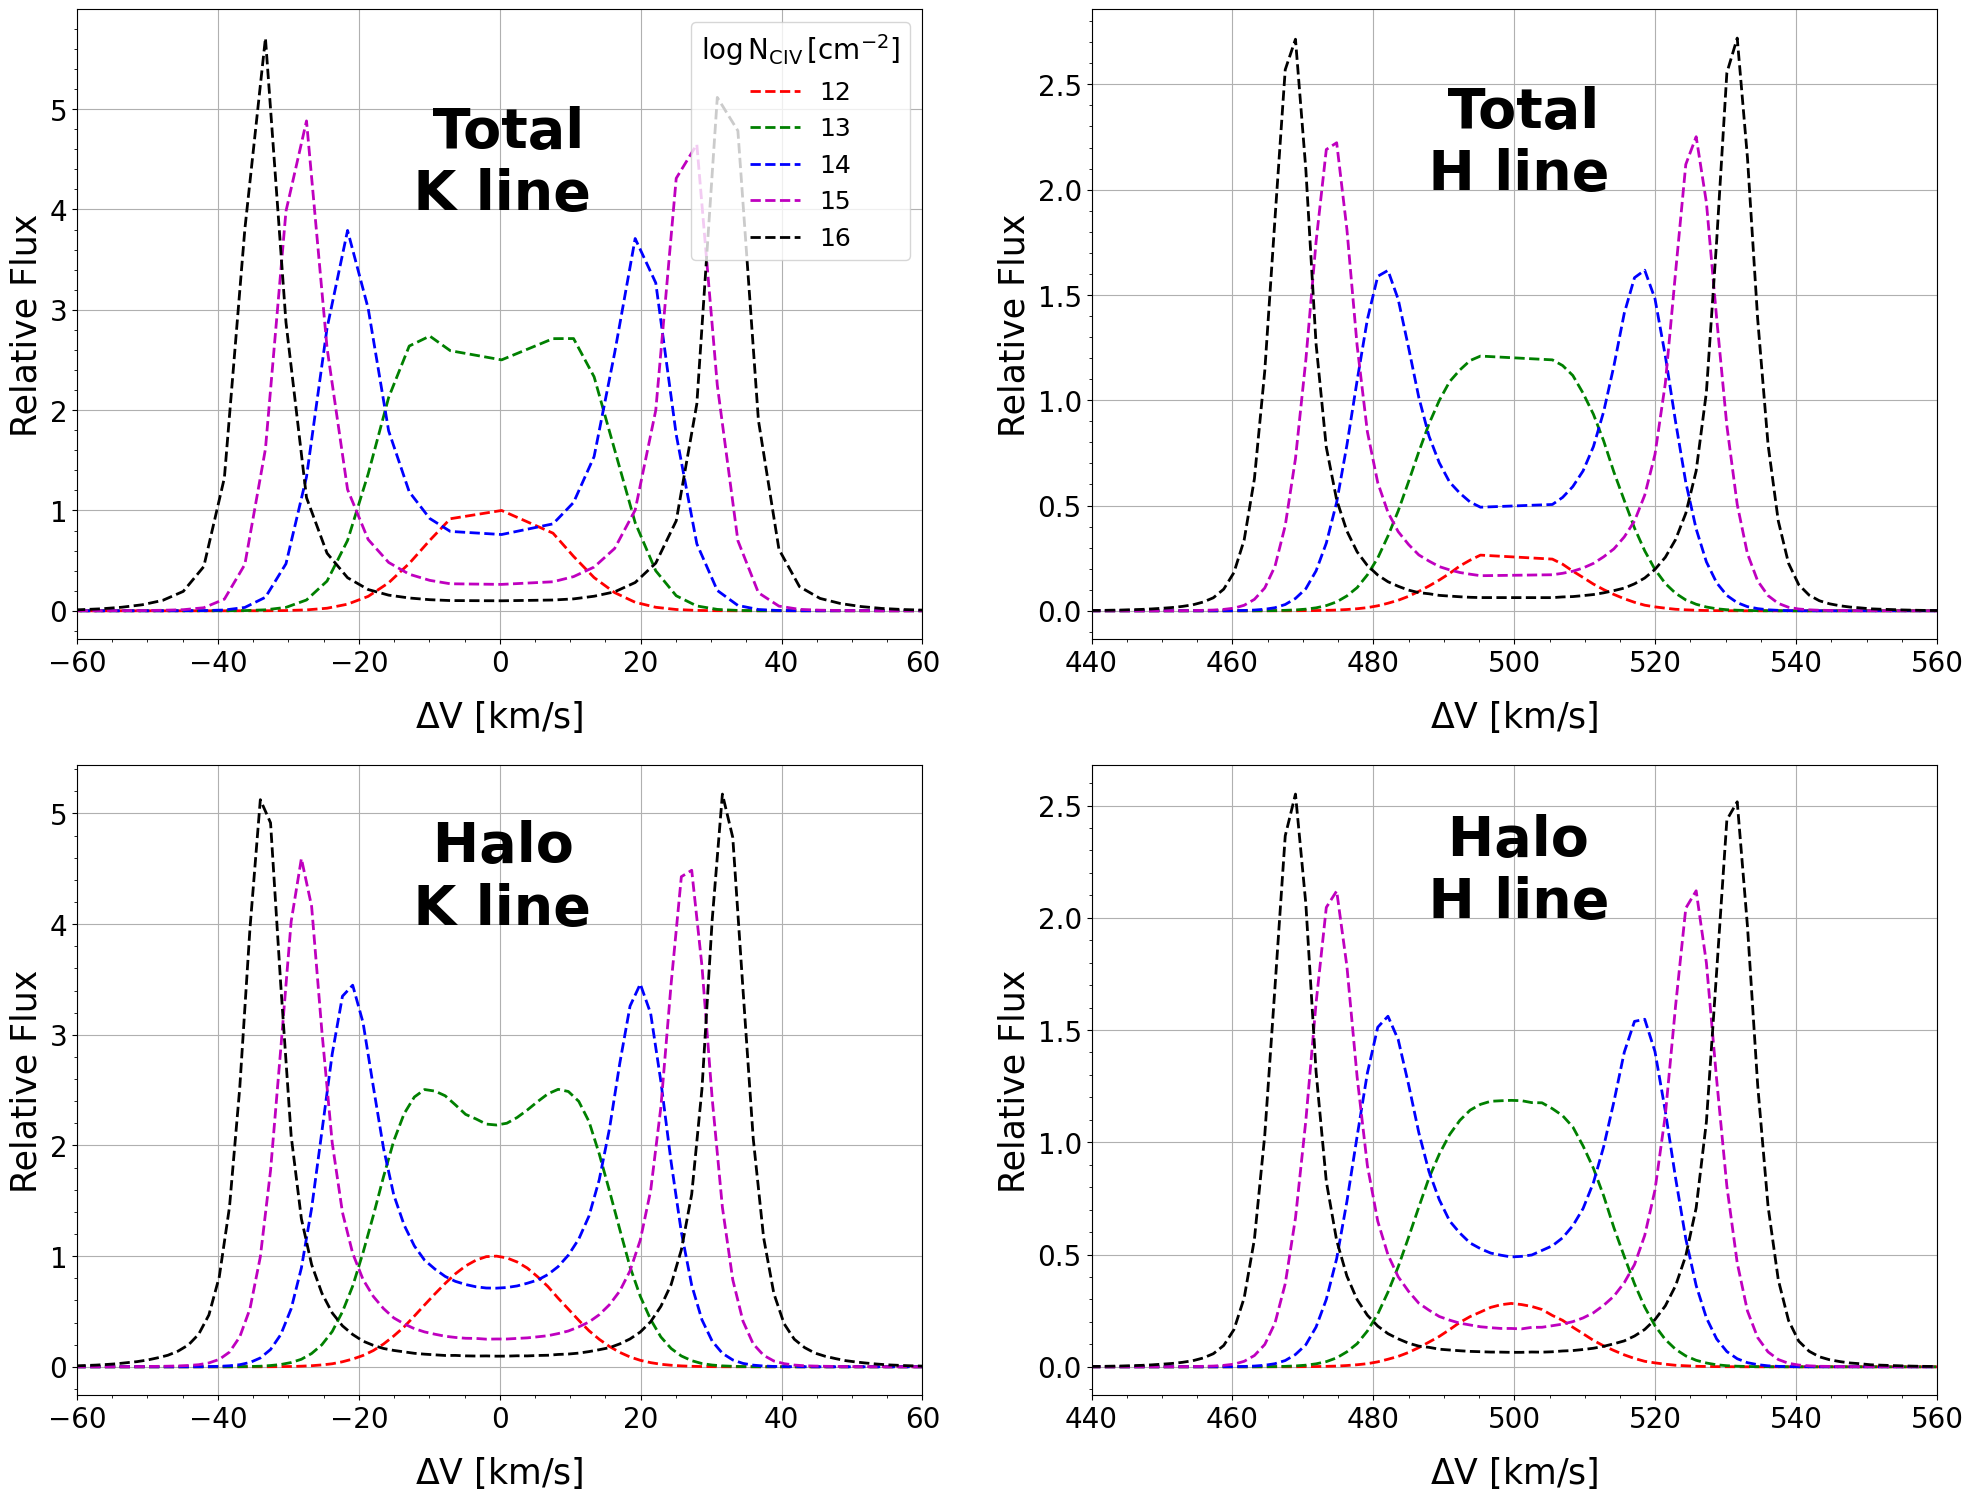

In [14]:
# fig= plt.figure(1,figsize=(15, 10))

fig= plt.figure(1,figsize=(24, 18))
v_ran = 118


atom= 79
plt.subplot(221)
index= 12
normal = globals()[f'tot_y_K_{atom}_{index}_{v_ran}'].max()
# plt.plot( ((globals()[f'tot_x_K_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'tot_y_K_{atom}_{index}_{v_ran}']/normal,'r--',lw=2,label = f'{index}')
xx, yy = down_resolution(globals()[f'tot_x_K_{atom}_{index}_{v_ran}'],globals()[f'tot_y_K_{atom}_{index}_{v_ran}'],2)
normal = yy.max()
plt.plot( ((xx/C_IV_K_A) - 1)*cc_k,yy/normal,'r--',lw=2,label = f'{index}')
index = 13
xx, yy = down_resolution(globals()[f'tot_x_K_{atom}_{index}_{v_ran}'],globals()[f'tot_y_K_{atom}_{index}_{v_ran}'],2)
# normal = yy.max()
plt.plot( ((xx/C_IV_K_A) - 1)*cc_k,yy/normal,'g--',lw=2,label = f'{index}')

index = 14
xx, yy = down_resolution(globals()[f'tot_x_K_{atom}_{index}_{v_ran}'],globals()[f'tot_y_K_{atom}_{index}_{v_ran}'],2)
# normal = yy.max()
plt.plot( ((xx/C_IV_K_A) - 1)*cc_k,yy/normal,'b--',lw=2,label = f'{index}')

index= 15
xx, yy = down_resolution(globals()[f'tot_x_K_{atom}_{index}_{v_ran}'],globals()[f'tot_y_K_{atom}_{index}_{v_ran}'],2)
# normal = yy.max()
plt.plot( ((xx/C_IV_K_A) - 1)*cc_k,yy/normal,'m--',lw=2,label = f'{index}')

index= 16
xx, yy = down_resolution(globals()[f'tot_x_K_{atom}_{index}_{v_ran}'],globals()[f'tot_y_K_{atom}_{index}_{v_ran}'],2)
# normal = yy.max()
plt.plot( ((xx/C_IV_K_A) - 1)*cc_k,yy/normal,'k--',lw=2,label = f'{index}')

plt.xlim(-60,60)
plt.xlabel(r'$\Delta \rm V $ [km/s]', fontsize=25, labelpad=15)
plt.ylabel('Relative Flux', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.minorticks_on()
plt.grid(True)
plt.text(x=-15,y=4.0,s='  Total \n K line',size=40,fontweight='bold')
plt.legend(loc='upper right',fontsize=18, title=r'$\log{\rm N_{\rm C IV}} \, [\rm cm^{-2}]$', title_fontsize=20, ncol=1)

plt.subplot(222)
index= 12
normal = globals()[f'tot_y_K_{atom}_{index}_{v_ran}'].max()
plt.plot( ((globals()[f'tot_x_H_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'tot_y_H_{atom}_{index}_{v_ran}']/normal,'r--',lw=2,label = f'{index}')

index = 13
plt.plot( ((globals()[f'tot_x_H_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'tot_y_H_{atom}_{index}_{v_ran}']/normal,'g--',lw=2,label = f'{index}')
# plt.plot( globals()[f'tot_x_H_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'tot_y_H_{atom}_{index}_{v_ran}']/normal,'g--')

index = 14
plt.plot( ((globals()[f'tot_x_H_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'tot_y_H_{atom}_{index}_{v_ran}']/normal,'b--',lw=2,label = f'{index}')
# plt.plot( globals()[f'tot_x_H_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'tot_y_H_{atom}_{index}_{v_ran}']/normal,'b--')

index= 15
plt.plot( ((globals()[f'tot_x_H_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'tot_y_H_{atom}_{index}_{v_ran}']/normal,'m--',lw=2,label = f'{index}')
# plt.plot( globals()[f'tot_x_H_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'tot_y_H_{atom}_{index}_{v_ran}']/normal,'m--')

index= 16
plt.plot( ((globals()[f'tot_x_H_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'tot_y_H_{atom}_{index}_{v_ran}']/normal,'k--',lw=2,label = f'{index}')
# plt.plot( globals()[f'tot_x_H_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'tot_y_H_{atom}_{index}_{v_ran}']/normal,'k--')

plt.xlim(440,560)
plt.xlabel(r'$\Delta \rm V $ [km/s]', fontsize=25, labelpad=15)
plt.ylabel('Relative Flux', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.minorticks_on()
plt.grid(True)
plt.text(x=485,y=2.0,s='  Total \n H line',size=40,fontweight='bold')


plt.subplot(223)
index= 12
normal = globals()[f'halo_y_K_{atom}_{index}_{v_ran}'].max()
plt.plot( ((globals()[f'halo_x_K_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'halo_y_K_{atom}_{index}_{v_ran}']/normal,'r--',lw=2,label = f'{index}')

index = 13
plt.plot( ((globals()[f'halo_x_K_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'halo_y_K_{atom}_{index}_{v_ran}']/normal,'g--',lw=2,label = f'{index}')
# plt.plot( globals()[f'halo_x_H_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'halo_y_H_{atom}_{index}_{v_ran}']/normal,'g--')

index = 14
plt.plot( ((globals()[f'halo_x_K_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'halo_y_K_{atom}_{index}_{v_ran}']/normal,'b--',lw=2,label = f'{index}')
# plt.plot( globals()[f'halo_x_H_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'halo_y_H_{atom}_{index}_{v_ran}']/normal,'b--')

index= 15
plt.plot( ((globals()[f'halo_x_K_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'halo_y_K_{atom}_{index}_{v_ran}']/normal,'m--',lw=2,label = f'{index}')
# plt.plot( globals()[f'halo_x_H_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'halo_y_H_{atom}_{index}_{v_ran}']/normal,'m--')

index= 16
plt.plot( ((globals()[f'halo_x_K_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'halo_y_K_{atom}_{index}_{v_ran}']/normal,'k--',lw=2,label = f'{index}')
# plt.plot( globals()[f'halo_x_H_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'halo_y_H_{atom}_{index}_{v_ran}']/normal,'k--')

plt.xlim(-60,60)
plt.xlabel(r'$\Delta \rm V $ [km/s]', fontsize=25, labelpad=15)
plt.ylabel('Relative Flux', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.minorticks_on()
plt.grid(True)
plt.text(x=-15,y=4.0,s='  Halo \n K line',size=40,fontweight='bold')

plt.subplot(224)
index= 12
normal = globals()[f'halo_y_K_{atom}_{index}_{v_ran}'].max()
plt.plot( ((globals()[f'halo_x_H_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'halo_y_H_{atom}_{index}_{v_ran}']/normal,'r--',lw=2,label = f'{index}')

index = 13
plt.plot( ((globals()[f'halo_x_H_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'halo_y_H_{atom}_{index}_{v_ran}']/normal,'g--',lw=2,label = f'{index}')
# plt.plot( globals()[f'halo_x_H_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'halo_y_H_{atom}_{index}_{v_ran}']/normal,'g--')

index = 14
plt.plot( ((globals()[f'halo_x_H_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'halo_y_H_{atom}_{index}_{v_ran}']/normal,'b--',lw=2,label = f'{index}')
# plt.plot( globals()[f'halo_x_H_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'halo_y_H_{atom}_{index}_{v_ran}']/normal,'b--')

index= 15
plt.plot( ((globals()[f'halo_x_H_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'halo_y_H_{atom}_{index}_{v_ran}']/normal,'m--',lw=2,label = f'{index}')
# plt.plot( globals()[f'halo_x_H_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'halo_y_H_{atom}_{index}_{v_ran}']/normal,'m--')

index= 16
plt.plot( ((globals()[f'halo_x_H_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'halo_y_H_{atom}_{index}_{v_ran}']/normal,'k--',lw=2,label = f'{index}')
# plt.plot( globals()[f'halo_x_H_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'halo_y_H_{atom}_{index}_{v_ran}']/normal,'k--')


plt.xlim(440,560)
plt.xlabel(r'$\Delta \rm V $ [km/s]', fontsize=25, labelpad=15)
plt.ylabel('Relative Flux', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.minorticks_on()
plt.grid(True)
plt.text(x=485,y=2.0,s='  Halo \n H line',size=40,fontweight='bold')

# plt.savefig('/home/jin/바탕화면/line_Total_halo_mono.pdf',bbox_inches="tight")

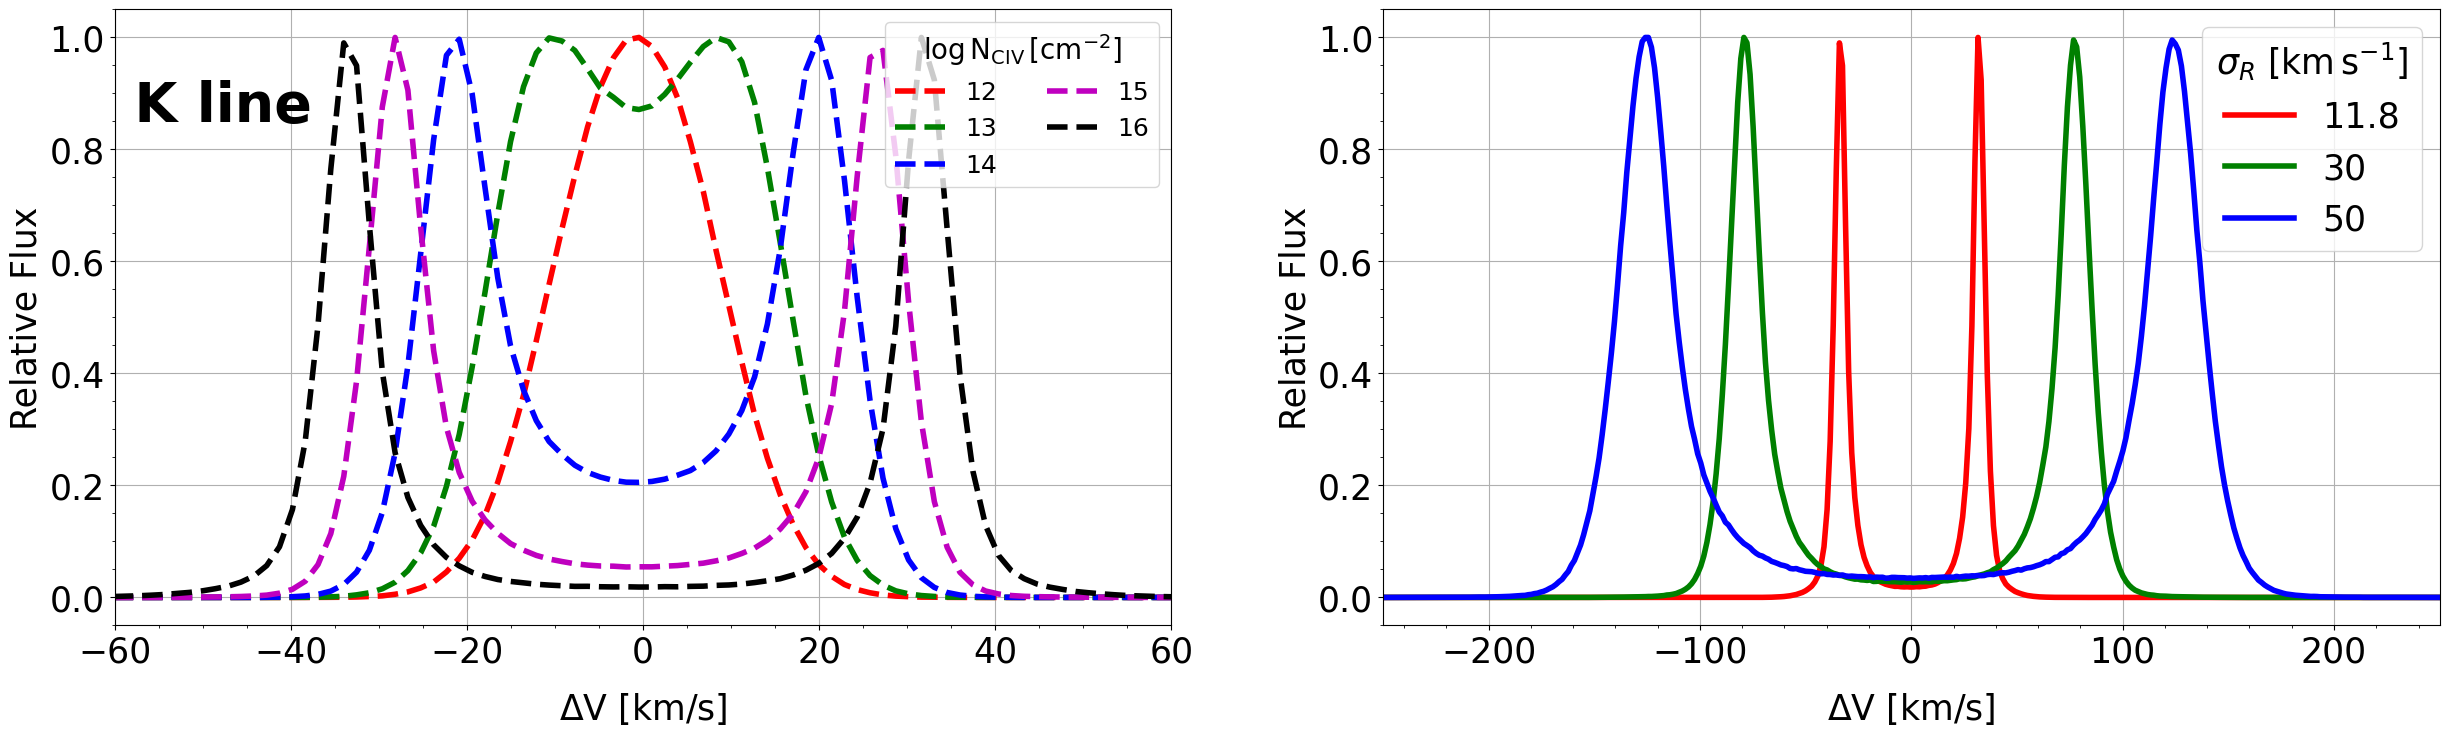

In [41]:
# fig= plt.figure(1,figsize=(15, 10))

fig= plt.figure(1,figsize=(30, 8))
v_ran = 118


atom= 79

lw_s = 4
plt.subplot(121)
index= 12
normal = globals()[f'halo_y_K_{atom}_{index}_{v_ran}'].max()
plt.plot( ((globals()[f'halo_x_K_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'halo_y_K_{atom}_{index}_{v_ran}']/normal,'r--',lw = lw_s,label = f'{index}')

index = 13
normal = globals()[f'halo_y_K_{atom}_{index}_{v_ran}'].max()
plt.plot( ((globals()[f'halo_x_K_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'halo_y_K_{atom}_{index}_{v_ran}']/normal,'g--',lw = lw_s,label = f'{index}')
# plt.plot( globals()[f'halo_x_K_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'halo_y_K_{atom}_{index}_{v_ran}']/normal,'g--')

index = 14
normal = globals()[f'halo_y_K_{atom}_{index}_{v_ran}'].max()
plt.plot( ((globals()[f'halo_x_K_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'halo_y_K_{atom}_{index}_{v_ran}']/normal,'b--',lw = lw_s,label = f'{index}')
# plt.plot( globals()[f'halo_x_K_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'halo_y_K_{atom}_{index}_{v_ran}']/normal,'b--')

index= 15
normal = globals()[f'halo_y_K_{atom}_{index}_{v_ran}'].max()
plt.plot( ((globals()[f'halo_x_K_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'halo_y_K_{atom}_{index}_{v_ran}']/normal,'m--',lw = lw_s,label = f'{index}')
# plt.plot( globals()[f'halo_x_K_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'halo_y_K_{atom}_{index}_{v_ran}']/normal,'m--')

index= 16
normal = globals()[f'halo_y_K_{atom}_{index}_{v_ran}'].max()
plt.plot( ((globals()[f'halo_x_K_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'halo_y_K_{atom}_{index}_{v_ran}']/normal,'k--',lw = lw_s,label = f'{index}')
# plt.plot( globals()[f'halo_x_K_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'halo_y_K_{atom}_{index}_{v_ran}']/normal,'k--')

plt.xlim(-60,60)
plt.xlabel(r'$\Delta \rm V $ [km/s]', fontsize=25, labelpad=15)
plt.ylabel('Relative Flux', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.minorticks_on()
plt.grid(True)
plt.text(x=-60,y=0.85,s=' K line',size=40,fontweight='bold')
plt.legend(loc='upper right',fontsize=18, title=r'$\log{\rm N_{\rm C IV}} \, [\rm cm^{-2}]$', title_fontsize=20, ncol=2)

plt.subplot(122)

v_ran = 118
normal = globals()[f'halo_y_K_{atom}_{index}_{v_ran}'].max()
plt.plot( ((globals()[f'halo_x_K_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'halo_y_K_{atom}_{index}_{v_ran}']/normal,'r-',lw = lw_s,label = '11.8')
# plt.plot( globals()[f'halo_x_K_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'halo_y_K_{atom}_{index}_{v_ran}']/normal,'k--')

v_ran = 30
normal = globals()[f'halo_y_K_{atom}_{index}_{v_ran}'].max()
# normal = globals()[f'halo_y_K_{atom}_{index}_{v_ran}'].max()
plt.plot( ((globals()[f'halo_x_K_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'halo_y_K_{atom}_{index}_{v_ran}']/normal,'g-',lw = lw_s,label = f'{v_ran }')

v_ran = 50
normal = globals()[f'halo_y_K_{atom}_{index}_{v_ran}'].max()
plt.plot( ((globals()[f'halo_x_K_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'halo_y_K_{atom}_{index}_{v_ran}']/normal,'b-',lw = lw_s,label = f'{v_ran }')
# plt.plot( globals()[f'halo_x_K_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'halo_y_K_{atom}_{index}_{v_ran}']/normal,'g--')


# v_ran = 118
# plt.plot( ((globals()[f'halo_x_K_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'halo_y_K_{atom}_{index}_{v_ran}']/normal,'k--',lw = lw_s,label = f'{index}')
# plt.plot( globals()[f'halo_x_K_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'halo_y_K_{atom}_{index}_{v_ran}']/normal,'k--')

plt.xlim(-250,250)
plt.xlabel(r'$\Delta \rm V $ [km/s]', fontsize=25, labelpad=15)
plt.ylabel('Relative Flux', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.minorticks_on()
plt.grid(True)
# plt.text(x=-15,y=4.0,s=' K line',size=40,fontweight='bold')
plt.legend(loc='upper right',fontsize=25, title=r'$\sigma_R ~ [\rm km\,s^{-1}]$', title_fontsize=25, ncol=1)


# plt.savefig('/home/jin/바탕화면/Monochromatic_line_K.pdf',bbox_inches="tight")

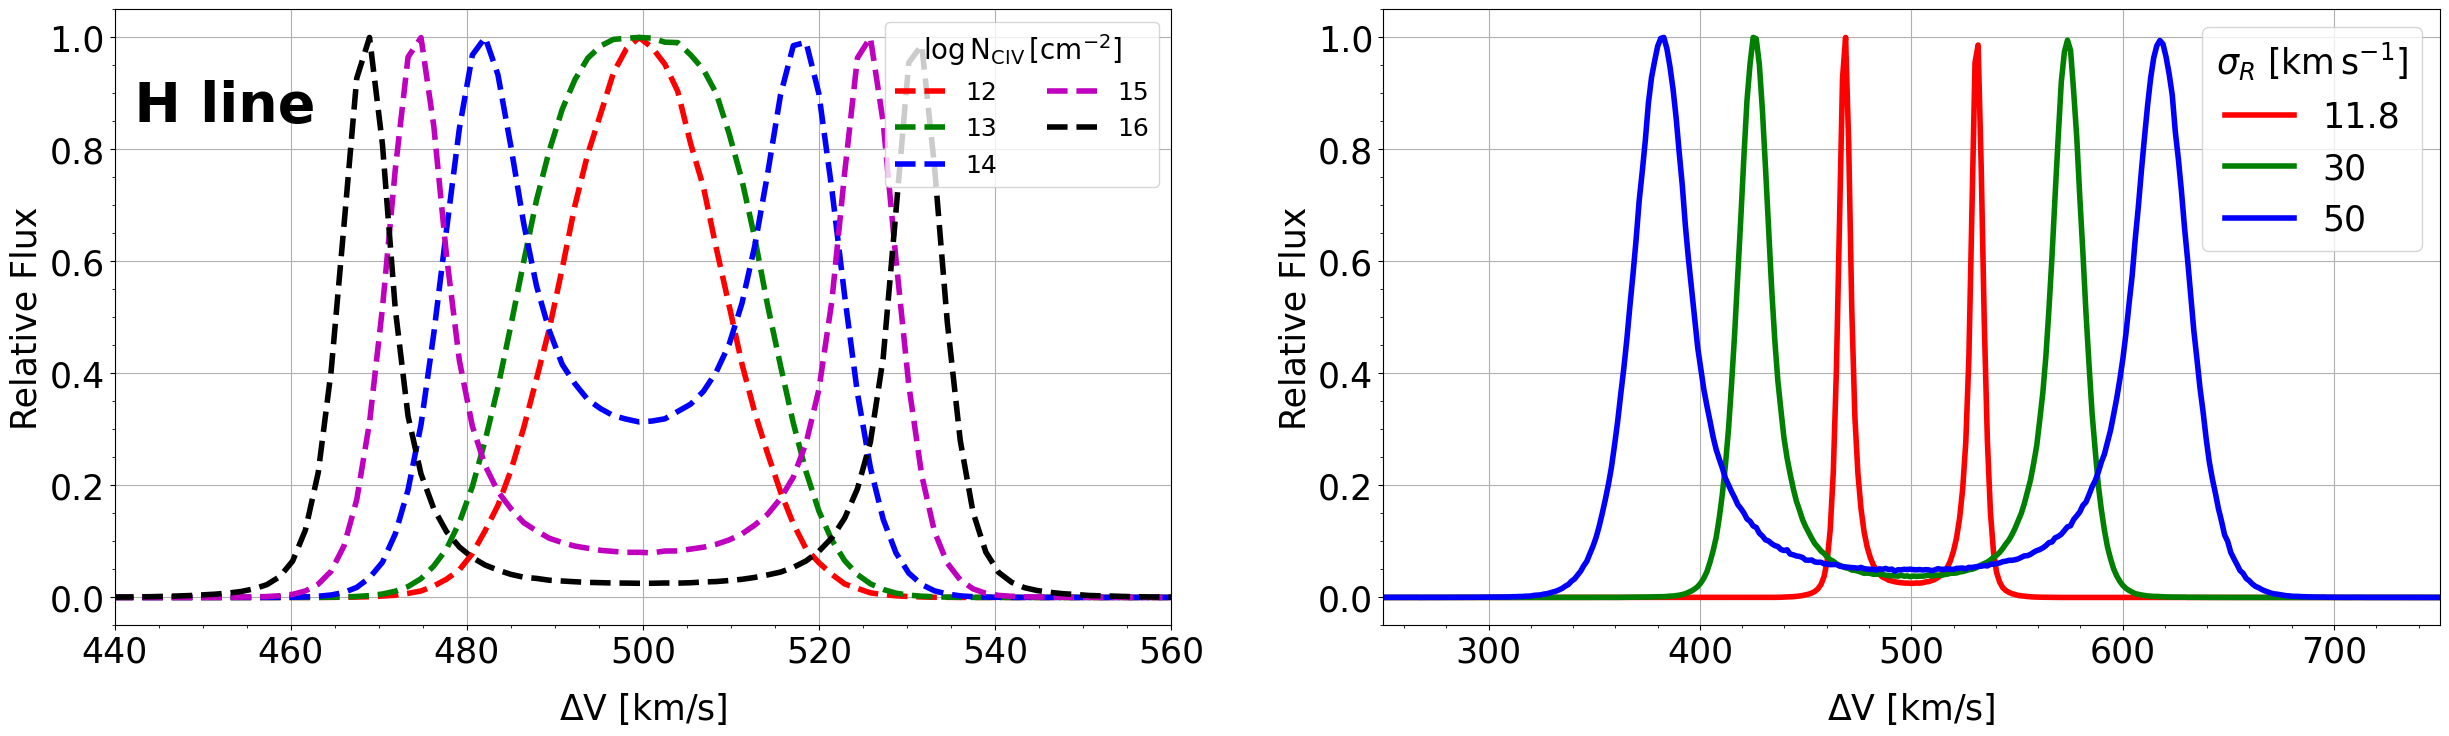

In [43]:
# fig= plt.figure(1,figsize=(15, 10))

fig= plt.figure(1,figsize=(30, 8))
v_ran = 118


atom= 79

lw_s = 4
plt.subplot(121)
index= 12
normal = globals()[f'halo_y_H_{atom}_{index}_{v_ran}'].max()
plt.plot( ((globals()[f'halo_x_H_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'halo_y_H_{atom}_{index}_{v_ran}']/normal,'r--',lw = lw_s,label = f'{index}')

index = 13
normal = globals()[f'halo_y_H_{atom}_{index}_{v_ran}'].max()
plt.plot( ((globals()[f'halo_x_H_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'halo_y_H_{atom}_{index}_{v_ran}']/normal,'g--',lw = lw_s,label = f'{index}')
# plt.plot( globals()[f'halo_x_H_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'halo_y_H_{atom}_{index}_{v_ran}']/normal,'g--')

index = 14
normal = globals()[f'halo_y_H_{atom}_{index}_{v_ran}'].max()
plt.plot( ((globals()[f'halo_x_H_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'halo_y_H_{atom}_{index}_{v_ran}']/normal,'b--',lw = lw_s,label = f'{index}')
# plt.plot( globals()[f'halo_x_H_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'halo_y_H_{atom}_{index}_{v_ran}']/normal,'b--')

index= 15
normal = globals()[f'halo_y_H_{atom}_{index}_{v_ran}'].max()
plt.plot( ((globals()[f'halo_x_H_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'halo_y_H_{atom}_{index}_{v_ran}']/normal,'m--',lw = lw_s,label = f'{index}')
# plt.plot( globals()[f'halo_x_H_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'halo_y_H_{atom}_{index}_{v_ran}']/normal,'m--')

index= 16
normal = globals()[f'halo_y_H_{atom}_{index}_{v_ran}'].max()
plt.plot( ((globals()[f'halo_x_H_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'halo_y_H_{atom}_{index}_{v_ran}']/normal,'k--',lw = lw_s,label = f'{index}')
# plt.plot( globals()[f'halo_x_H_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'halo_y_H_{atom}_{index}_{v_ran}']/normal,'k--')

plt.xlim(440,560)
plt.xlabel(r'$\Delta \rm V $ [km/s]', fontsize=25, labelpad=15)
plt.ylabel('Relative Flux', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.minorticks_on()
plt.grid(True)
plt.text(x=440,y=0.85,s=' H line',size=40,fontweight='bold')
plt.legend(loc='upper right',fontsize=18, title=r'$\log{\rm N_{\rm C IV}} \, [\rm cm^{-2}]$', title_fontsize=20, ncol=2)

plt.subplot(122)

v_ran = 118
normal = globals()[f'halo_y_H_{atom}_{index}_{v_ran}'].max()
plt.plot( ((globals()[f'halo_x_H_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'halo_y_H_{atom}_{index}_{v_ran}']/normal,'r-',lw = lw_s,label = '11.8')
# plt.plot( globals()[f'halo_x_H_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'halo_y_H_{atom}_{index}_{v_ran}']/normal,'k--')

v_ran = 30
normal = globals()[f'halo_y_H_{atom}_{index}_{v_ran}'].max()
# normal = globals()[f'halo_y_H_{atom}_{index}_{v_ran}'].max()
plt.plot( ((globals()[f'halo_x_H_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'halo_y_H_{atom}_{index}_{v_ran}']/normal,'g-',lw = lw_s,label = f'{v_ran }')

v_ran = 50
normal = globals()[f'halo_y_H_{atom}_{index}_{v_ran}'].max()
plt.plot( ((globals()[f'halo_x_H_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'halo_y_H_{atom}_{index}_{v_ran}']/normal,'b-',lw = lw_s,label = f'{v_ran }')
# plt.plot( globals()[f'halo_x_H_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'halo_y_H_{atom}_{index}_{v_ran}']/normal,'g--')


# v_ran = 118
# plt.plot( ((globals()[f'halo_x_H_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'halo_y_H_{atom}_{index}_{v_ran}']/normal,'k--',lw = lw_s,label = f'{index}')
# plt.plot( globals()[f'halo_x_H_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'halo_y_H_{atom}_{index}_{v_ran}']/normal,'k--')

plt.xlim(250,750)
plt.xlabel(r'$\Delta \rm V $ [km/s]', fontsize=25, labelpad=15)
plt.ylabel('Relative Flux', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.minorticks_on()
plt.grid(True)
# plt.text(x=-15,y=4.0,s=' K line',size=40,fontweight='bold')
plt.legend(loc='upper right',fontsize=25, title=r'$\sigma_R ~ [\rm km\,s^{-1}]$', title_fontsize=25, ncol=1)


plt.savefig('/home/jin/바탕화면/Monochromatic_line_H.pdf',bbox_inches="tight")

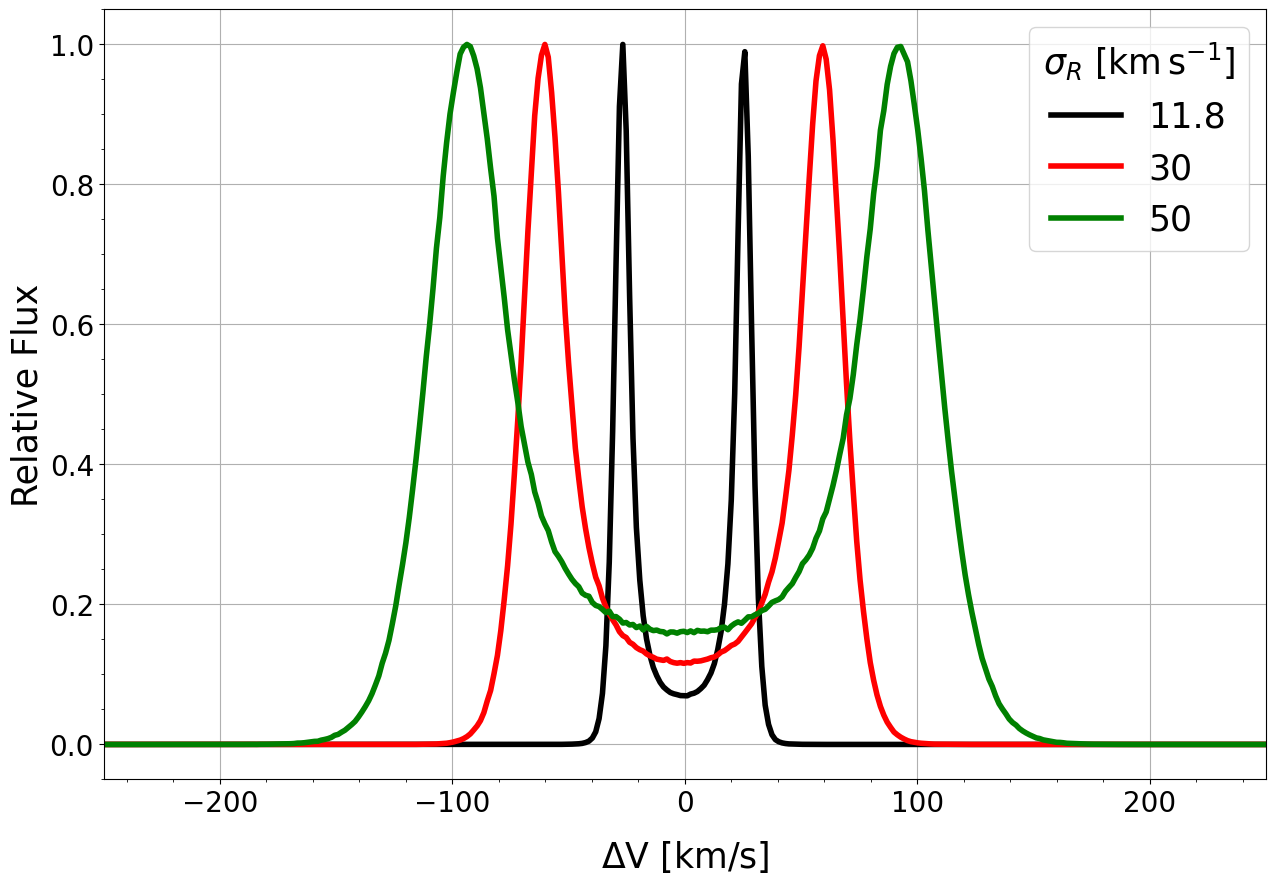

In [16]:
# fig= plt.figure(1,figsize=(15, 10))

fig= plt.figure(1,figsize=(15, 10))
v_ran = 118


atom= 50
index= 15
lw_s = 4
normal = globals()[f'halo_y_K_{atom}_{index}_{v_ran}'].max()
# plt.subplot(211)


v_ran = 118
normal = globals()[f'halo_y_K_{atom}_{index}_{v_ran}'].max()
plt.plot( ((globals()[f'halo_x_K_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'halo_y_K_{atom}_{index}_{v_ran}']/normal,'k-',lw = lw_s,label = '11.8')
# plt.plot( globals()[f'halo_x_H_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'halo_y_H_{atom}_{index}_{v_ran}']/normal,'k--')

v_ran = 30
normal = globals()[f'halo_y_K_{atom}_{index}_{v_ran}'].max()
# normal = globals()[f'halo_y_K_{atom}_{index}_{v_ran}'].max()
plt.plot( ((globals()[f'halo_x_K_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'halo_y_K_{atom}_{index}_{v_ran}']/normal,'r-',lw = lw_s,label = f'{v_ran }')

v_ran = 50
normal = globals()[f'halo_y_K_{atom}_{index}_{v_ran}'].max()
plt.plot( ((globals()[f'halo_x_K_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'halo_y_K_{atom}_{index}_{v_ran}']/normal,'g-',lw = lw_s,label = f'{v_ran }')
# plt.plot( globals()[f'halo_x_H_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'halo_y_H_{atom}_{index}_{v_ran}']/normal,'g--')


# v_ran = 118
# plt.plot( ((globals()[f'halo_x_K_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'halo_y_K_{atom}_{index}_{v_ran}']/normal,'k--',lw = lw_s,label = f'{index}')
# plt.plot( globals()[f'halo_x_H_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'halo_y_H_{atom}_{index}_{v_ran}']/normal,'k--')

plt.xlim(-250,250)
plt.xlabel(r'$\Delta \rm V $ [km/s]', fontsize=25, labelpad=15)
plt.ylabel('Relative Flux', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.minorticks_on()
plt.grid(True)
# plt.text(x=-15,y=4.0,s=' K line',size=40,fontweight='bold')
plt.legend(loc='upper right',fontsize=25, title=r'$\sigma_R ~ [\rm km\,s^{-1}]$', title_fontsize=25, ncol=1)

# plt.subplot(212)

# v_ran = 118
# plt.plot( ((globals()[f'halo_x_H_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'halo_y_H_{atom}_{index}_{v_ran}']/normal,'k-',lw = lw_s,label = '11.8')
# # plt.plot( globals()[f'halo_x_H_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'halo_y_H_{atom}_{index}_{v_ran}']/normal,'k--')

# v_ran = 30
# # normal = globals()[f'halo_y_H_{atom}_{index}_{v_ran}'].max()
# plt.plot( ((globals()[f'halo_x_H_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'halo_y_H_{atom}_{index}_{v_ran}']/normal,'r-',lw = lw_s,label = f'{v_ran }')


# v_ran = 50
# plt.plot( ((globals()[f'halo_x_H_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'halo_y_H_{atom}_{index}_{v_ran}']/normal,'g-',lw = lw_s,label = f'{v_ran }')
# # plt.plot( globals()[f'halo_x_H_{atom}_{index}_{v_ran}'] - C_IV_K_A,globals()[f'halo_y_H_{atom}_{index}_{v_ran}']/normal,'g--')



# plt.xlim(350,650)
# plt.xlabel(r'$\Delta \rm V $ [km/s]', fontsize=25, labelpad=15)
# plt.ylabel('Relative Flux', fontsize=25)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.minorticks_on()
# plt.grid(True)
# # plt.text(x=485,y=2.0,s=' H line',size=40,fontweight='bold')

# plt.savefig('/home/jin/바탕화면/line_Total_halo_random_mono.png',bbox_inches="tight")

(-250.0, 750.0)

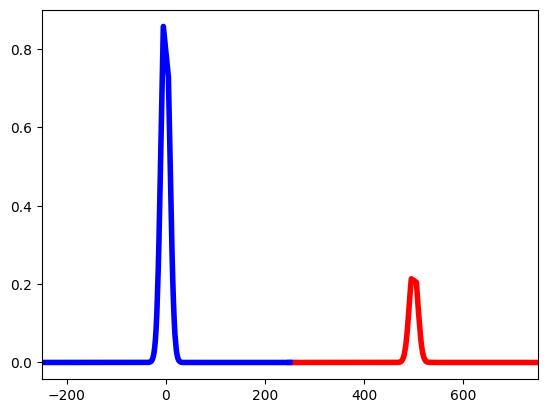

In [17]:
atom = 50
index = 12
v_ran = 118
plt.plot( ((globals()[f'tot_x_H_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'tot_y_H_{atom}_{index}_{v_ran}']/normal,'r-',lw = lw_s,label = f'{v_ran }')
plt.plot( ((globals()[f'tot_x_K_{atom}_{index}_{v_ran}']/C_IV_K_A) - 1)*cc_k,globals()[f'tot_y_K_{atom}_{index}_{v_ran}']/normal,'b-',lw = lw_s,label = f'{v_ran }')
plt.xlim(-250,750)

In [18]:
check = 0
def CIV(T,ff):
    sigma_Lya = 5.9e-14 * (T / 1e4) ** (-1/2)
    sigma_CIV = (ff / 0.4164) * sigma_Lya * (12) ** (0.5)

    return sigma_CIV

for tt,v_ran in enumerate(random_vel):
    n = 0
    if v_ran == 11.8 :
        index_v_ran = 1
        v_title = int(v_ran*10)
        v_ran = int(v_ran*10)
    elif v_ran < 100:
        index_v_ran = 1
        v_title = int(v_ran*10)
    elif v_ran >= 1000:
        index_v_ran = 3
        v_title = int(v_ran/10)
    else :
        index_v_ran = 2
        v_title = int(v_ran)
        
    globals()[f'tot_V_K_peak_{v_ran}'] = np.zeros(len(rr)*len(atom_N))
    globals()[f'V_H_peak_{v_ran}'] = np.zeros(len(rr)*len(atom_N))
    globals()[f'tot_scat_{v_ran}'] = np.zeros(len(rr)*len(atom_N))
    globals()[f'tot_xx_{v_ran}']= np.zeros(len(rr)*len(atom_N))
    iou = 1e5
    sig_c= CIV(iou,f_CIV_K)
    globals()[f'tot_C_iv_{v_ran}'],globals()[f'tot_N_scat_{v_ran}'],globals()[f'tot_V_del_peak_{v_ran}'] = N_esc_scat(random_vel[tt]*1e5)

    for ii, index in enumerate(rr):
        index = int(index)
        for jj, atom in enumerate(atom_N):
            atom = int(atom)
            path_sp = f'{directory_1}N_atom{atom}0E+{index}_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran{v_title}E+0{index_v_ran}spec_com.dat'
            path_scat = f'{directory_1}N_atom{atom}0E+{index}_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran{v_title}E+0{index_v_ran}_f_esc.dat'
            path_sp_dat = f'{directory_1}N_atom{atom}0E+{index}_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran{v_title}E+0{index_v_ran}spec.dat'

            try:
                data_sp = pd.read_csv(path_sp, sep='\s+', header=None)
                data_scat = pd.read_csv(path_scat, sep='\s+', header=None)
                data_sp_dat = pd.read_csv(path_sp_dat, sep='\s+', header=None)
            except FileNotFoundError:
                print(f"파일을 찾을 수 없습니다: {path_sp}")
                print(f"파일을 찾을 수 없습니다: {path_scat}")
                print(f"파일을 찾을 수 없습니다: {path_sp_dat}")
                check += 1
                continue

            globals()[f'data_sp_dat_{atom}_{index}_{v_ran}'] = pd.read_csv(path_sp_dat, sep='\s+', header=None)

            globals()[f'lam_{atom}_{index}_{v_ran}'] = globals()[f'data_sp_dat_{atom}_{index}_{v_ran}'][0]
            globals()[f'K_int_{atom}_{index}_{v_ran}'] = globals()[f'data_sp_dat_{atom}_{index}_{v_ran}'][1]
            globals()[f'H_int_{atom}_{index}_{v_ran}'] = globals()[f'data_sp_dat_{atom}_{index}_{v_ran}'][2]
            globals()[f'K_sct_{atom}_{index}_{v_ran}'] = globals()[f'data_sp_dat_{atom}_{index}_{v_ran}'][3]
            globals()[f'H_sct_{atom}_{index}_{v_ran}'] = globals()[f'data_sp_dat_{atom}_{index}_{v_ran}'][4]

            globals()[f'data_scat_{atom}_{index}_{v_ran}'] = pd.read_csv(path_scat, sep='\s+', header=None)
            
            globals()[f'tot_scat_{v_ran}'][n] = float(globals()[f'data_scat_{atom}_{index}_{v_ran}'].iloc[0,4])
            
            # Read data
            globals()[f'data_tot_sp_{atom}_{index}_{v_ran}'] = pd.read_csv(path_sp, sep='\s+', header=None)
            globals()[f'tot_sp_dlam_{atom}_{index}_{v_ran}'] = globals()[f'data_tot_sp_{atom}_{index}_{v_ran}'][0]
            globals()[f'tot_sp_{atom}_{index}_{v_ran}'] = globals()[f'data_tot_sp_{atom}_{index}_{v_ran}'][1]

            # K and H line separate
            lam_c = (C_IV_K_A + C_IV_H_A) / 2
            # K line
            globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'] = globals()[f'tot_sp_dlam_{atom}_{index}_{v_ran}'][globals()[f'tot_sp_dlam_{atom}_{index}_{v_ran}'] <= lam_c]
            globals()[f'tot_flux_K_{atom}_{index}_{v_ran}'] = globals()[f'tot_sp_{atom}_{index}_{v_ran}'][globals()[f'tot_sp_dlam_{atom}_{index}_{v_ran}'] <= lam_c]
            # H line
            globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'] = globals()[f'tot_sp_dlam_{atom}_{index}_{v_ran}'][globals()[f'tot_sp_dlam_{atom}_{index}_{v_ran}'] >= lam_c]
            globals()[f'tot_flux_H_{atom}_{index}_{v_ran}'] = globals()[f'tot_sp_{atom}_{index}_{v_ran}'][globals()[f'tot_sp_dlam_{atom}_{index}_{v_ran}'] >= lam_c]

            # K line double peak separate

            Fraction = 0   #0.000018
            C_IV_K_P = C_IV_K_A +  C_IV_K_A*Fraction 
            C_IV_K_N = C_IV_K_A  -  C_IV_K_A*Fraction 

            X_K_P = globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'][globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'] >= C_IV_K_P ].to_numpy()
            X_K_N = globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'][globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'] <= C_IV_K_N].to_numpy()
            filtered_series_K_pos_1 = globals()[f'tot_flux_K_{atom}_{index}_{v_ran}'][globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'] >= C_IV_K_P ].to_numpy()
            filtered_series_K_neg_1 = globals()[f'tot_flux_K_{atom}_{index}_{v_ran}'][globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'] <= C_IV_K_N].to_numpy()

            tt_K = (globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'] <= C_IV_K_N) | (globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'] >= C_IV_K_P )

            globals()[f'tot_x_K_{atom}_{index}_{v_ran}'] = np.compress(tt_K, globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'])
            globals()[f'tot_y_K_{atom}_{index}_{v_ran}'] = np.compress(tt_K, globals()[f'tot_flux_K_{atom}_{index}_{v_ran}'])

            # H line double peak separate
            C_IV_H_P = C_IV_H_A +  C_IV_H_A*Fraction 
            C_IV_H_N = C_IV_H_A -  C_IV_H_A*Fraction 

            X_H_P = globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'][globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'] >= C_IV_H_P].to_numpy()
            X_H_N = globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'][globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'] <= C_IV_H_N].to_numpy()
            filtered_series_H_pos_1 = globals()[f'tot_flux_H_{atom}_{index}_{v_ran}'][globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'] >= C_IV_H_P].to_numpy()
            filtered_series_H_neg_1 = globals()[f'tot_flux_H_{atom}_{index}_{v_ran}'][globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'] <= C_IV_H_N].to_numpy()

            tt_H = (globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'] <= C_IV_H_N) | (globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'] >= C_IV_H_P)

            globals()[f'tot_x_H_{atom}_{index}_{v_ran}'] = np.compress(tt_H, globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'])
            globals()[f'tot_y_H_{atom}_{index}_{v_ran}'] = np.compress(tt_H, globals()[f'tot_flux_H_{atom}_{index}_{v_ran}'])

            # Get peak indices
            K_p_1 = np.argmax(filtered_series_K_pos_1)
            K_n_1 = np.argmax(filtered_series_K_neg_1)

            H_p_1 = np.argmax(filtered_series_H_pos_1)
            H_n_1 = np.argmax(filtered_series_H_neg_1)

            lam_K_R = X_K_P[K_p_1]
            lam_K_B = X_K_N[K_n_1]
            
            lam_H_R = X_H_P[H_p_1]
            lam_H_B = X_H_P[H_n_1]

            Dlam = lam_K_R - lam_K_B
            vv = v_ran * 1e5

            # if vv / v_th_CIV < 1.2:
            #     dK_H = (1548.218 - 1548.156) * 1.5 
            # else:
            #     dK_H = (1548.218 - 1548.156) * 0.85 
            dK_H = 0.1
            if Dlam <= dK_H:
                del_V_peak_K = 0
            else:
                del_V_peak_K = (Dlam / C_IV_K_A) * cc / 1e5     

            globals()[f'tot_V_K_peak_{v_ran}'][n] = del_V_peak_K
            globals()[f'tot_xx_{v_ran}'][n] = 10**index * atom / 10
            n += 1

print(check)


0


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

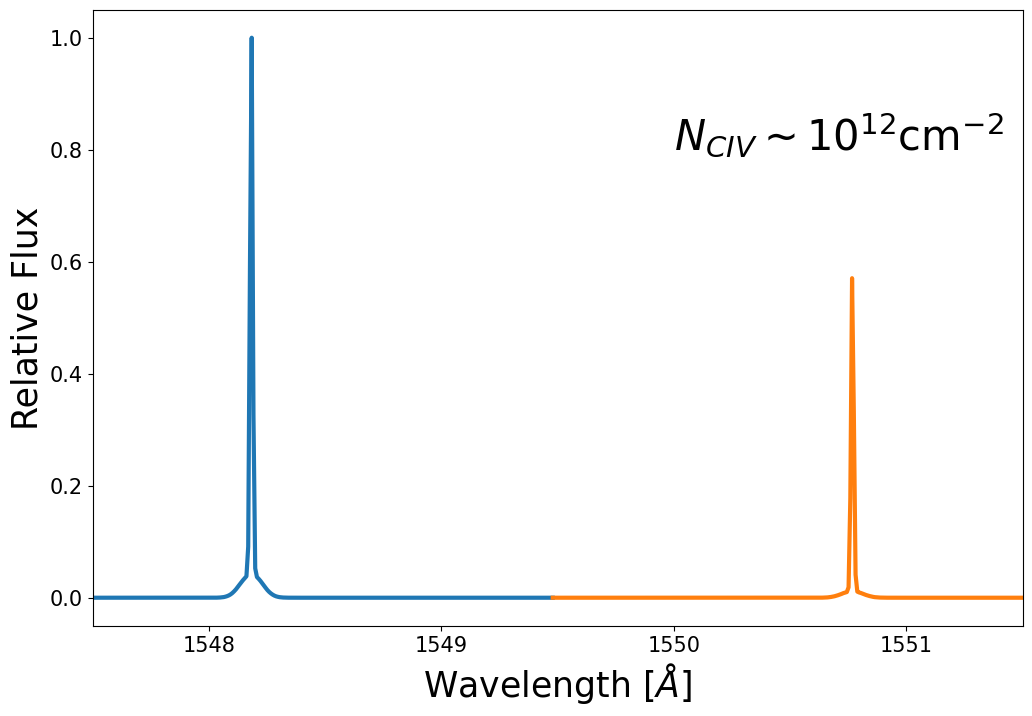

In [19]:
fig = plt.figure(1,figsize=(12,8))
normal_f = tot_y_K_79_12_118.max()
plt.plot(tot_x_K_79_12_118 ,tot_y_K_79_12_118/ normal_f,lw=3)
plt.plot(tot_x_H_79_12_118 ,tot_y_H_79_12_118 / normal_f ,lw= 3)

plt.xlim(1547.5,1551.5)
plt.text(1550,0.8,r'$N_{CIV} \sim 10^{12} \rm cm^{-2}$',size=30)
plt.xlabel(r'Wavelength $[\AA]$',fontsize=25)
plt.ylabel('Relative Flux',fontsize= 25)

plt.xticks([1548,1549,1550,1551],fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig('/home/jin/바탕화면/Optically thin.png',bbox_inches='tight')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

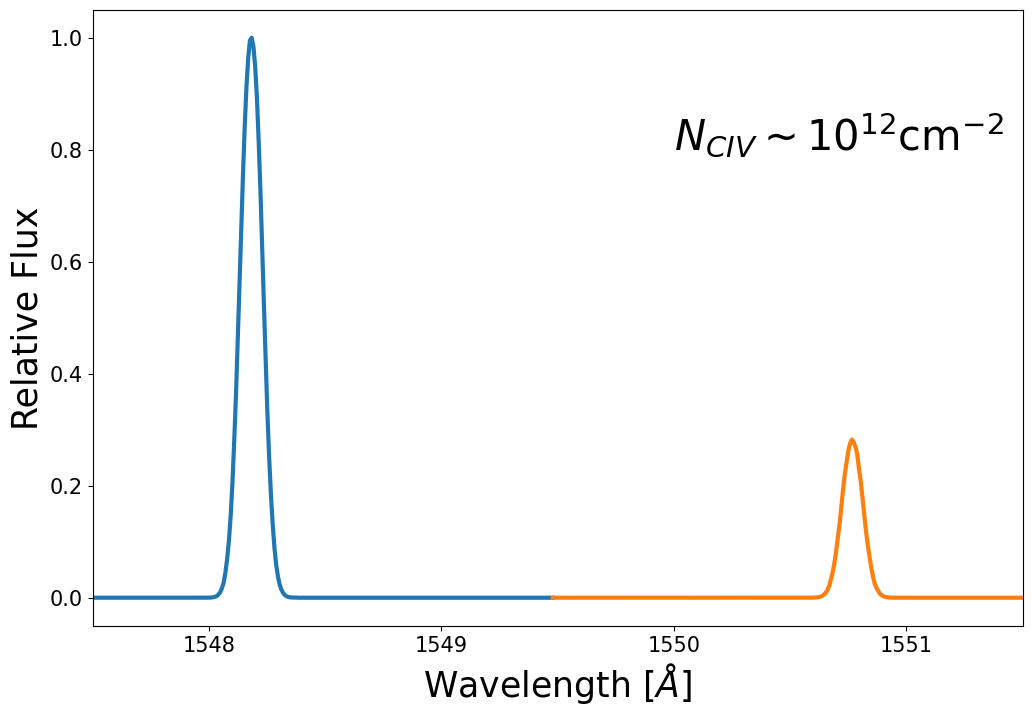

In [20]:
fig = plt.figure(1,figsize=(12,8))
normal_f = halo_y_K_79_12_118.max()
plt.plot(halo_x_K_79_12_118 ,halo_y_K_79_12_118/ normal_f,lw=3)
plt.plot(halo_x_H_79_12_118 ,halo_y_H_79_12_118 / normal_f ,lw= 3)

plt.xlim(1547.5,1551.5)
plt.text(1550,0.8,r'$N_{CIV} \sim 10^{12} \rm cm^{-2}$',size=30)
plt.xlabel(r'Wavelength $[\AA]$',fontsize=25)
plt.ylabel('Relative Flux',fontsize= 25)

plt.xticks([1548,1549,1550,1551],fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig('/home/jin/바탕화면/Halo_Optically thin.png',bbox_inches='tight')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0')])

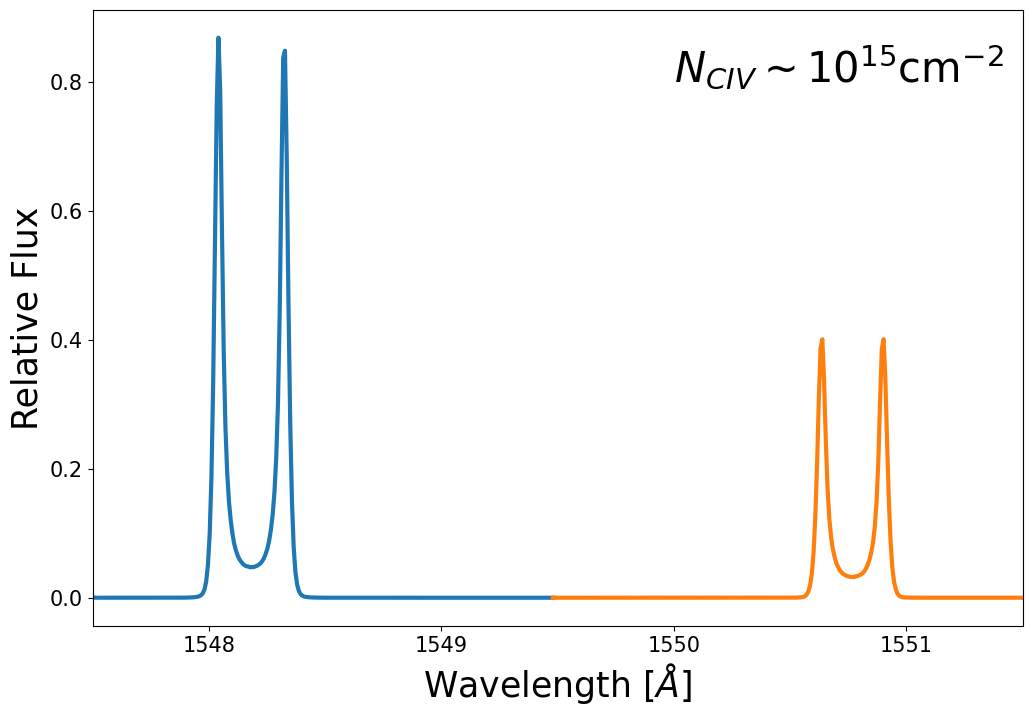

In [21]:
fig = plt.figure(1,figsize=(12,8))
normal_f = tot_y_K_79_15_118.max()
plt.plot(halo_x_K_79_15_118 ,halo_y_K_79_15_118/ normal_f,lw=3)
plt.plot(halo_x_H_79_15_118 ,halo_y_H_79_15_118 / normal_f ,lw=3)

plt.xlim(1547.5,1551.5)
plt.text(1550,0.8,r'$N_{CIV} \sim 10^{15} \rm cm^{-2}$',size=30)
plt.xlabel(r'Wavelength $[\AA]$',fontsize=25)
plt.ylabel('Relative Flux',fontsize= 25)

plt.xticks([1548,1549,1550,1551],fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig('/home/jin/바탕화면/Halo_Optically thick.png',bbox_inches='tight')

(0.0, 5.0)

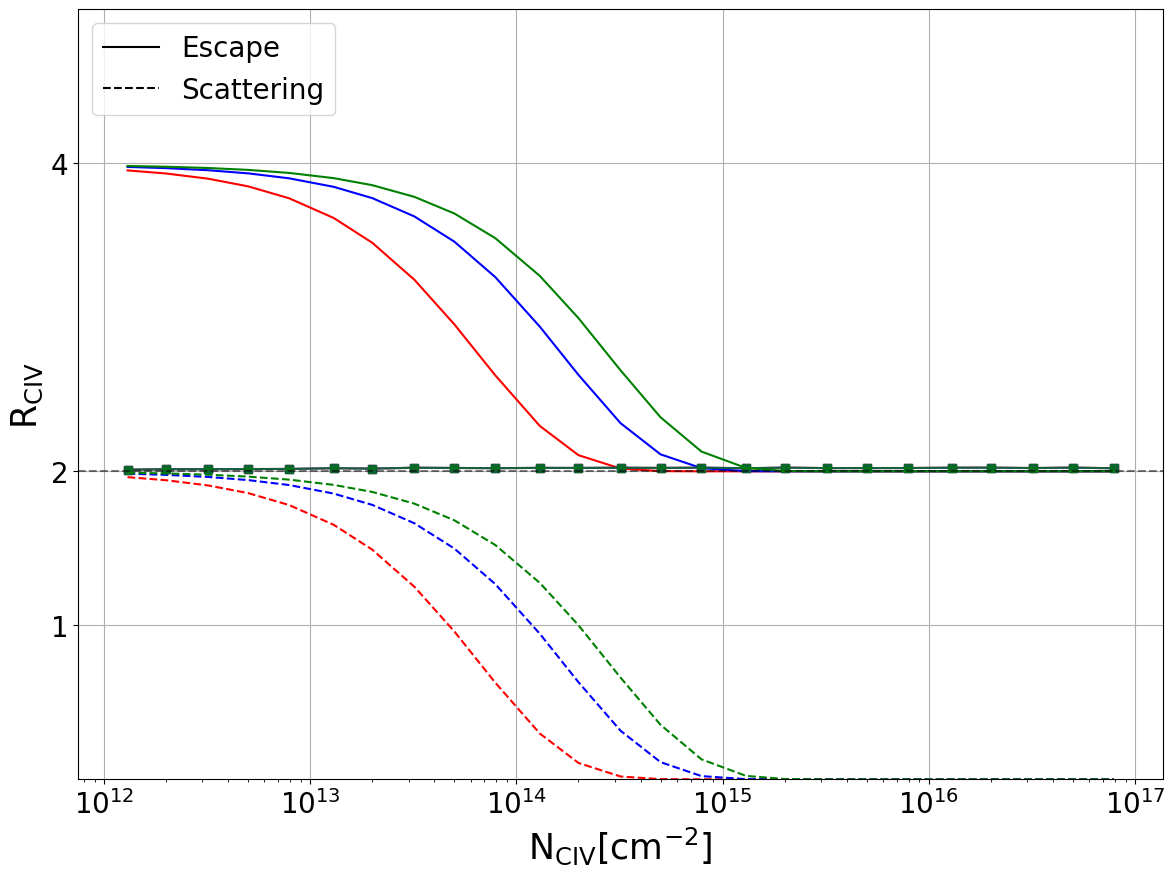

In [22]:

import math
rr = np.arange(12, 17, 1, dtype=np.float128)
atom_N = [13,20,32,50,79]
total_N_c = np.outer(10**rr, atom_N) / 10
total_N_c = total_N_c.flatten()
lam_c = (C_IV_H_A+ C_IV_K_A) / 2
def inf_K(x,y):
    xx = np.where(x >=(C_IV_K_A - lam_c))[0]
    x = x[xx]
    y = y[xx] 
    dx = x[1]- x[0]
    summ = np.sum(dx*y,axis=0)
    return summ
def inf_H(x,y):
    xx = np.where(x <=(C_IV_H_A + lam_c))[0]
    x = x[xx]
    y = y[xx] 
    dx = x[1]- x[0]
    summ = np.sum(dx*y,axis=0)
    return summ


random_vel= [11.8,30,50,100,150]
ratio_h = np.zeros((len(random_vel),len(total_N_c)))
ratio_t = np.zeros((len(random_vel),len(total_N_c)))

for ii,vel_k in enumerate(random_vel):
    if vel_k == 11.8 :
         vel_k = 118
    for jj, N_civ in enumerate(total_N_c):
            index = math.floor(math.log10(N_civ))
            atom_n = int(N_civ/ 10**index * 10)

            a_1 = inf_K(globals()[f'halo_x_K_{atom_n}_{index}_{vel_k}'],globals()[f'halo_y_K_{atom_n}_{index}_{vel_k}'])
            a_2 = inf_H(globals()[f'halo_x_H_{atom_n}_{index}_{vel_k}'],globals()[f'halo_y_H_{atom_n}_{index}_{vel_k}'])
            ratio_h[ii][jj] = a_1/ a_2

            a_3 = inf_K(globals()[f'tot_x_K_{atom_n}_{index}_{vel_k}'],globals()[f'tot_y_K_{atom_n}_{index}_{vel_k}'])
            a_4 = inf_H(globals()[f'tot_x_H_{atom_n}_{index}_{vel_k}'],globals()[f'tot_y_H_{atom_n}_{index}_{vel_k}'])
            ratio_t[ii][jj] = a_3/ a_4
def CIV(T,ff):
    sigma_Lya = 5.9e-14 * (T / 1e4) ** (-1/2)
    sigma_CIV = (ff / 0.4164) * sigma_Lya * (12) ** (0.5)

    return sigma_CIV



def analytic_Ratio(intrin_r, f_K,f_H, N_CIV,v_th):
     sig_K = CIV(1e5,f_K)
     sig_H = CIV(1e5,f_H)
     tau_K = tau(sig_K,N_CIV) * v_th_CIV/ (v_th *1e5) 
     tau_H = tau(sig_H,N_CIV) * v_th_CIV/ (v_th*1e5) 
     ratio = intrin_r * (1-np.exp(-tau_K)) / (1-np.exp(-tau_H))
     ratio_1 = intrin_r * (np.exp(-tau_K)) / (np.exp(-tau_H)) 
     return ratio , ratio_1

fig = plt.figure(1,figsize=(14,10))



vel_k= 118
# plt.plot(total_N_c, ratio_h[0][:], 'ro-',alpha=0.5,label=f'{vel_k} $[\\rm km s^{{-1}}]$')
plt.plot(total_N_c, ratio_t[0][:], 'rs-',alpha=0.7,label=f'{vel_k / 10} $[\\rm km s^{{-1}}]$')
analy_ratio , ratio_1 = analytic_Ratio(2,f_CIV_K,f_CIV_H,total_N_c,vel_k/10)
plt.plot(total_N_c,analy_ratio,'r-')
plt.plot(total_N_c,ratio_1,'r--')

# test_1 = (analy_ratio * ratio_1)
# plt.plot(total_N_c,test_1,'b--')
# plt.plot(total_N_c, ratio_h[0][:], 'r:', marker='s', alpha=0.5)

vel_k= 30
# plt.plot(total_N_c, ratio_h[1][:], 'bo-',alpha=0.5,label=f'{vel_k}$[\\rm km s^{{-1}}]$')
plt.plot(total_N_c, ratio_t[0][:], 'bs-',alpha=0.7,label=f'{vel_k} $[\\rm km s^{{-1}}]$')
analy_ratio, ratio_1 = analytic_Ratio(2,f_CIV_K,f_CIV_H,total_N_c,vel_k)
plt.plot(total_N_c,analy_ratio,'b-')
plt.plot(total_N_c,ratio_1,'b--')

vel_k= 50
# plt.plot(total_N_c, ratio_h[2][:], 'go-',alpha=0.5,label=f'{vel_k} $[\\rm km s^{{-1}}]$')
plt.plot(total_N_c, ratio_t[0][:], 'gs-',alpha=0.7,label=f'{vel_k} $[\\rm km s^{{-1}}]$')
analy_ratio, ratio_1 = analytic_Ratio(2,f_CIV_K,f_CIV_H,total_N_c,vel_k)
plt.plot(total_N_c,analy_ratio,'g-')
plt.plot(total_N_c,ratio_1,'g--')



plt.legend()
plt.xscale('log')
plt.xlabel(r'${\rm N}_{\rm C IV} [\rm cm^{-2}]$',fontsize=25)
plt.ylabel(r'${\rm R}_{\rm C IV} $',fontsize=25)
plt.xticks(fontsize=20)
# plt.gca().yaxis.set_major_formatter(ScalarFormatter())

import matplotlib.lines as mlines
outflow_line = mlines.Line2D([], [], color='black',linestyle='-', label='Escape')
inflow_line = mlines.Line2D([], [], color='black', linestyle='--', label='Scattering')

# # Add a second legend
second_legend = plt.legend(handles=[outflow_line, inflow_line], loc='upper left', fontsize=20)

# plt.axhline(y=0.25,xmin=0,xmax=1,linestyle='--',color='k')
plt.axhline(y=2.0,xmin=0,xmax=1,linestyle='--',color='k',alpha=0.5)
plt.grid(True)
# plt.yscale('log')
plt.yticks([1,2,4], fontsize=20)
plt.ylim(0,5)
# plt.savefig('/home/jin/바탕화면/Escape_Scattering_Ratio_in_monochromatic_Total.pdf',bbox_inches='tight')

Optically thin 할 땐, escaping frcaction이 우세해서, 2가 되고, optically thick 해지면서 escaping으로 인한 결과가 아니라, scattering으로 인한 결과로 완성. 

그리고 Tau  ~ $N_{CIV}/  \sigma_R$ 임으로, $\sigma_R$ 이 커질 수록, tau는 상대적으로 줄어든다. 그래서 column denisty 가 더 큰 쪽에서 맞춰지는 거임. 

/tmp/ipykernel_9317/1978528816.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


(0.0, 5.0)

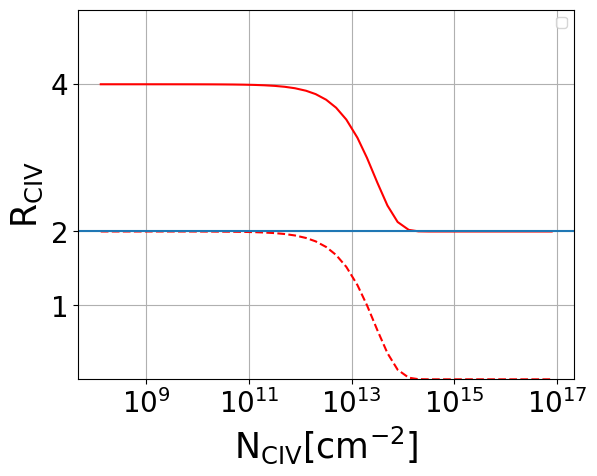

In [23]:

def analytic_Ratio(intrin_r, f_K,f_H, N_CIV,v_th):
     sig_K = CIV(1e5,f_K)
     sig_H = CIV(1e5,f_H)
     tau_K = tau(sig_K,N_CIV) * v_th_CIV/ (v_th *1e5) 
     tau_H = tau(sig_H,N_CIV) * v_th_CIV/ (v_th*1e5) 
     ratio = intrin_r * (1-np.exp(-tau_K)) / (1-np.exp(-tau_H))
     ratio_1 = intrin_r * (np.exp(-tau_K)) / (np.exp(-tau_H)) 
     return ratio , ratio_1

rr = np.arange(8, 17, 1, dtype=np.float128)
atom_N = [13,20,32,50,79]
total_N_c = np.outer(10**rr, atom_N) / 10
total_N_c = total_N_c.flatten()

analy_ratio , ratio_1 = analytic_Ratio(2,f_CIV_K,f_CIV_H,total_N_c,vel_k/10)
plt.plot(total_N_c,analy_ratio,'r-')
plt.plot(total_N_c,ratio_1,'r--')
plt.legend()
plt.xscale('log')
plt.xlabel(r'${\rm N}_{\rm C IV} [\rm cm^{-2}]$',fontsize=25)
plt.ylabel(r'${\rm R}_{\rm C IV} $',fontsize=25)
plt.xticks(fontsize=20)
# plt.gca().yaxis.set_major_formatter(ScalarFormatter())

# plt.legend('-')
# plt.axhline(y=0.25,xmin=0,xmax=1,linestyle='--',color='k')
plt.axhline(y=2.0,xmin=0,xmax=1)
plt.grid(True)
# plt.yscale('log')
plt.yticks([1,2,4], fontsize=20)
plt.ylim(0,5)

(1546.0, 1550.0)

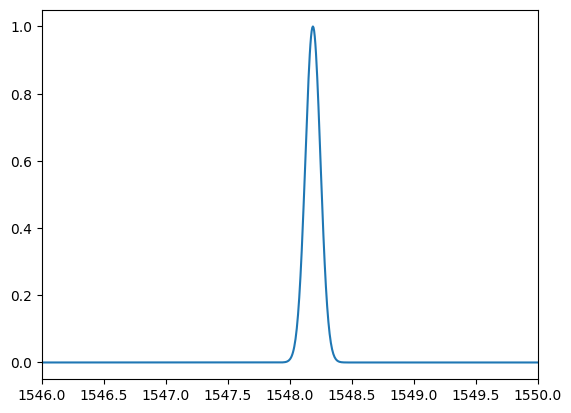

In [24]:
xx = np.linspace(1530,1580,10000)
def fexp(xx,sig):
    top = (xx-C_IV_K_A)**2 *(cc/C_IV_K_A)**2 
    tt = top / (2*sig**2)
    return np.exp(-tt) / np.exp(-tt).max()
yy = fexp(xx,v_th_CIV)

# yy_ray = (3/(16*np.pi)) * (1+)
plt.plot(xx,yy)
plt.xlim(1546,1550)